# Tech Challenge 4
**Autora:** Glynda Calazans

**RM:** 357444

**Grupo:** 40

**Turma:** 6DTAT


---




**Objetivos do Projeto:**


1. **Coleta de dados:** Obter dados históricos do preço do petróleo brent.

2. **Construção de um modelo preditivo:** Criar um modelo de Machine Learning para prever o preço diário do petróleo.

3. **Desenvolvimento do dashboard:** Criar um dashboard interativo para visualizar as variações do preço do petróleo e os insights gerados.

4. **Storytelling:** Demonstrar todo o processo, desde a captura e tratamento dos dados até a modelagem, visualização e insights.

5. **Geração de insights:** Apresentar pelo menos quatro insights relevantes sobre a variação do preço do petróleo, considerando fatores como situações geopolíticas, crises econômicas e demanda global por energia.

6. **Deploy do modelo:** Desenvolver um plano de produção e criar um MVP funcional utilizando Streamlit.

8. **Apresentação final:** Elaborar um vídeo de até 5 minutos explicando o desenvolvimento do projeto.

## Bibliotecas & Métricas


In [48]:
! pip install scikit-learn xgboost tqdm
!pip install pmdarima
!pip install ipeadatapy

import pandas as pd
import numpy as np

# Visualização de Dados
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf as _plot_acf
from statsmodels.graphics.tsaplots import plot_pacf as _plot_pacf

import seaborn as sns
sns.color_palette("light:b", as_cmap=True)

import plotly.express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots

# Coleta de Dados (Yahoo)
import yfinance as yf
import ipeadatapy as idpy

# Modelagem e Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#Análise de Tendencia, Sazonalidade e Resíduo
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose


In [49]:
#MODELOS
import statsmodels.api as sm
import xgboost as xgb
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

### Métricas de avaliação dos modelos

In [50]:
#Métricas para avaliar os modelos
from sklearn.metrics import r2_score
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    mean_squared_error,
)

# Funções de Avaliação
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    return mae, mse, mape

def print_metrics(metrics):
    mae, mse, mape = metrics
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"MAPE: {mape:.2f} %")

from scipy import stats

### Perfumaria

In [51]:
# Definir o estilo global usando plt.rcParams para os gráficos
plt.rcParams.update({
    'figure.figsize': (18, 5),  # Tamanho padrão das figuras
    'axes.facecolor': '#fdfefe',  # Fundo branco para os gráficos
    'axes.edgecolor': 'none',  # Remove o contorno (bordas dos gráficos)
    'grid.color': 'lightgray',  # Cor clara para o grid
    'grid.linestyle': '--',  # Estilo tracejado para o grid
    'grid.linewidth': 0.5,  # Espessura do grid
    'lines.linewidth': 1,  # Espessura padrão das linhas (corresponde à padronização escolhida)
    'lines.color': '#607d8b',  # Cor padrão das linhas
    'legend.frameon': True,  # Contorno da legenda
    'axes.spines.top': False,  # Remove o contorno superior
    'axes.spines.right': False,  # Remove o contorno direito
    'axes.spines.left': False,  # Remove o contorno esquerdo
    'axes.spines.bottom': False  # Remove o contorno inferior
})

#Filtro para avisos
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore")

## Dataset


As colunas do dataset tratado do Ibovespa são as seguintes:

- **Data**: Dia em que o dado foi obtido
- **Fechamento**: Indica o valor da ação do último fechamento do dia
- **Abertura**: Indica o primeiro valor da ação do dia
- **Máxima**: Cotação máxima do dia
- **Minima**: Cotação mínima do dia
- **Volume (M)**: Indica o fluxo de negociações que ocorreram no dia em Milhão.

Colunas complementares para realizar análises:
- **Ano**: Ano em que o dado foi obtido
- **Mês**: Mês em que o dado foi obtido
- **Dia da Semana (dia_semana)**: Dia da semana em que o dado foi obtido (O Brent utiliza o fuso horário de londres e não funciona aos finais de semana).



### Yahoo! Finanças (Brent)

No Yahoo Finance, o Brent é listado pelo ticker BZ=F, permitindo o acompanhamento de sua cotação em tempo real, além de análises históricas e técnicas.

In [52]:
# @title
# Baixar dados do Brent
df = yf.download('BZ=F', start='2007-08-01', end='2025-02-28', progress=False)

# Tratamento
# df.drop(columns=['Adj Close'], inplace=True)
df.columns = ['fechamento', 'max', 'min', 'abertura', 'volume']

# Arredondar valores numéricos para 2 casas decimais
colunas_numericas = ['fechamento', 'max', 'min', 'abertura', 'volume']
df[colunas_numericas] = df[colunas_numericas].round(2)

# Adicionar colunas de data
# Garantir que o índice é um objeto datetime
df.index = pd.to_datetime(df.index)

# Adicionar coluna de ano
df['ano'] = df.index.year

# Adicionar coluna de mês
df['mês'] = df.index.month

# Adicionar coluna de dia da semana em português
dias_semana = {
    0: 'segunda',
    1: 'terça',
    2: 'quarta',
    3: 'quinta',
    4: 'sexta',
    5: 'sábado',
    6: 'domingo'
}
df['dia_semana'] = df.index.dayofweek.map(dias_semana)

# Visualizar o DataFrame
df

,fechamento,max,min,abertura,volume,ano,mês,dia_semana
Date,,,,,,,,
2007-08-01,75.35,77.06,74.86,77.00,3930,2007,8,quarta
2007-08-02,75.76,76.21,74.27,75.22,6180,2007,8,quinta
2007-08-03,74.75,76.00,74.53,75.39,4387,2007,8,sexta
2007-08-06,71.17,74.60,70.87,74.54,7201,2007,8,segunda
2007-08-07,71.80,72.01,70.56,70.80,6775,2007,8,terça
...,...,...,...,...,...,...,...,...
2025-02-21,74.43,76.75,74.21,76.56,28100,2025,2,sexta
2025-02-24,74.78,74.91,73.91,73.91,17858,2025,2,segunda
2025-02-25,73.02,75.25,72.70,74.89,19080,2025,2,terça


In [53]:
# Obter informações sobre o dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4371 entries, 2007-08-01 to 2025-02-27
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   fechamento  4371 non-null   float64
 1   max         4371 non-null   float64
 2   min         4371 non-null   float64
 3   abertura    4371 non-null   float64
 4   volume      4371 non-null   int64  
 5   ano         4371 non-null   int32  
 6   mês         4371 non-null   int32  
 7   dia_semana  4371 non-null   object 
dtypes: float64(4), int32(2), int64(1), object(1)
memory usage: 273.2+ KB


In [54]:
# Estatísticas descritivas do dataset
df.describe().round(2)

,fechamento,max,min,abertura,volume,ano,mês
count,4371.00,4371.00,4371.00,4371.00,4371.00,4371.00,4371.00
mean,78.61,79.58,77.58,78.61,18717.29,2015.93,6.58
std,24.23,24.32,24.08,24.21,16669.55,5.08,3.45
min,19.33,21.27,16.00,19.56,0.00,2007.00,1.00
25%,60.26,61.20,59.26,60.33,1341.00,2012.00,4.00
50%,76.67,77.59,75.65,76.67,19096.00,2016.00,7.00
75%,99.94,101.28,98.46,99.94,31335.50,2020.00,10.00
max,146.08,147.43,144.27,146.08,92049.00,2025.00,12.00


In [55]:
df.tail() #verifica se o dado esta ordenado e o ultimo é a ultima data mesmo

,fechamento,max,min,abertura,volume,ano,mês,dia_semana
Date,,,,,,,,
2025-02-21,74.43,76.75,74.21,76.56,28100,2025,2,sexta
2025-02-24,74.78,74.91,73.91,73.91,17858,2025,2,segunda
2025-02-25,73.02,75.25,72.70,74.89,19080,2025,2,terça
2025-02-26,72.53,73.34,72.39,73.14,11916,2025,2,quarta
2025-02-27,74.04,74.26,72.48,72.69,7925,2025,2,quinta


## 1. Análise Exploratória de Dados (AED)


### 1.1 Análise Geral do Cenário

**Brent Crude**

O Brent Crude é um dos principais benchmarks globais para a precificação do petróleo, sendo utilizado como referência nos mercados da Europa, Ásia e África. Seu nome vem do campo petrolífero Brent, descoberto em 1971 pela Shell no Mar do Norte. A partir da década de 1980, com o crescimento da produção na região, o Brent passou a ser amplamente utilizado como referência de preços no mercado internacional.

Atualmente, seus contratos futuros são negociados na ICE Futures Europe, onde servem como base para a precificação de grande parte do petróleo comercializado mundialmente. Seu preço reflete a oferta e demanda global por energia e é fortemente influenciado por fatores como instabilidade geopolítica, decisões da OPEP e estoques de petróleo nos EUA. Assim, o Brent funciona como um indicador do equilíbrio entre produção e consumo de petróleo no cenário global.

 **Periodo Analisado**

A partir dos dados diários de fechamento do Brent, extraídos do Yaho, para o período de agosto de 2007 (1º dado no yahoo) a fevereiro de 2025, foi construída uma série temporal que captura a intensa volatilidade do índice e sua sensibilidade a eventos internos e externos. A evolução do Brent ao longo dos últimos 18 anos pode ser visualizada no Gráfico 1, que servirá como ponto de partida para a nossa análise.

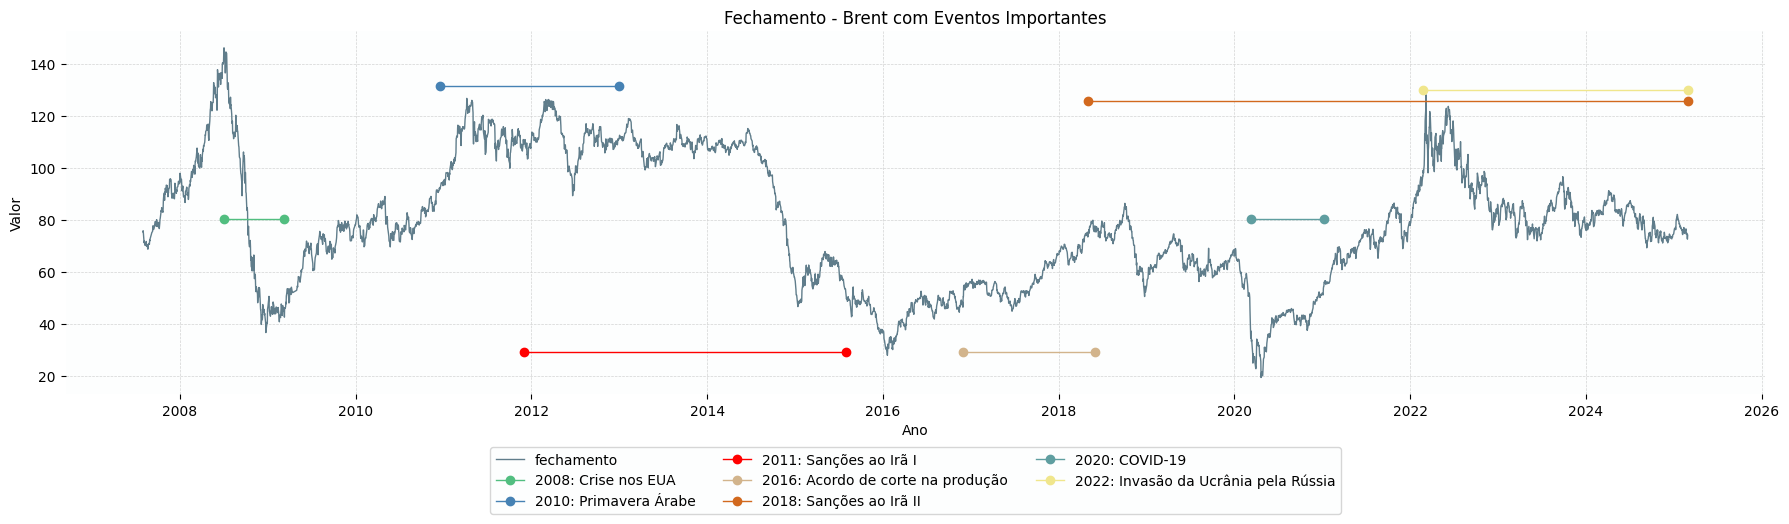

In [56]:
# @title

def plot_series_with_events(data, column, events, bars_data=None, title='', ylabel='', xlabel=''):

    ## Gráfico Principal (BRENT)
    plt.plot(data.index, data[column], label=column, color='#607d8b')

    # Definir intervalo de 2 anos no eixo X
    plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # Define o intervalo de 2 anos
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Formato do rótulo do eixo X

    ## Ilustrar Eventos que causam impacto

    # Cores e posições dos eventos
    colors = ['#52be80', '#4682B4', 'red','#D2B48C', '#D2691E', '#5F9EA0', '#F0E68C']
    y_positions = [max(data[column]) * 0.55, max(data[column]) * 0.9, max(data[column]) * 0.2,
                   max(data[column]) * 0.2, max(data[column]) * 0.86, max(data[column]) * 0.55, max(data[column]) * 0.89]

    # Adicionando os eventos ao gráfico
    for i, (inicio, fim, evento) in enumerate(zip(events['Início'], events['Fim'], events['Eventos'])):
        plt.plot([inicio, fim], [y_positions[i]] * 2, marker='o', color=colors[i], label=evento)

    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.grid(True)
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=3)
    # Ajustar o layout para acomodar a legenda na parte inferior
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)  # Ajuste este valor conforme necessário
    plt.show()

    # Criar DataFrame para os eventos
eventos = pd.DataFrame({
        'Eventos': ['2008: Crise nos EUA','2010: Primavera Árabe','2011: Sanções ao Irã I','2016: Acordo de corte na produção', '2018: Sanções ao Irã II','2020: COVID-19','2022: Invasão da Ucrânia pela Rússia'],
        'Início': [pd.Timestamp('2008-07-01'), pd.Timestamp('2010-12-17'),pd.Timestamp('2011-12-01'),pd.Timestamp('2016-12-01'),pd.Timestamp('2018-05-01'), pd.Timestamp('2020-03-11'), pd.Timestamp('2022-02-24')],
        'Fim': [pd.Timestamp('2009-03-09'), pd.Timestamp('2012-12-31'),pd.Timestamp('2015-07-30'),pd.Timestamp('2018-06-01'),pd.Timestamp('2025-03-01'), pd.Timestamp('2021-01-06'), pd.Timestamp('2025-03-01')]
})
# Usar a função para plotar a série do fechamento do BRENT com eventos
plot_series_with_events(data=df, column='fechamento', events=eventos,
                            title='Fechamento - Brent com Eventos Importantes',
                            ylabel='Valor', xlabel='Ano')


**Gráfico 1:** Série temporal do Brent (2007-2025) com destaque para os principais eventos que influenciaram sua trajetória.

 A análise da série permite identificar períodos de alta e baixa volatilidade, bem como a relação entre eventos específicos e as oscilações do índice. Em geral, a série apresenta uma tendência de crescimento geral ao longo do período, com quedas expressivas nos anos de 2008,2015, 2016 e 2020.


**REVER: Observa-se também uma sazonalidade anual, com aumentos mais concentrados no meio de cada ciclo e quedas mais acentuadas ao final (Gráfico 11). A decomposição da série temporal torna esses padrões ainda mais evidentes.**

#### 1.1.1 Eventos que causaram grande impacto no Brent
Saiba mais em detalhes:



**Crises e Recessões:**

*   **2008 - 2009** - **Crise financeira global** (setembro de 2008 a meados de 2009): A crise financeira de 2008, catalisada pela falência do Lehman Brothers em 15 de setembro de 2008 e uma série de colapsos no mercado imobiliário dos Estados Unidos, gerou uma crise de confiança nos mercados globais. Esse evento impactou significativamente o Brent que caiu de cerca de $145 (julho de 2008) para $36 (dezembro de 2008) devido à recessão global e queda na demanda.

*   **2020 - 2021** - **Pandemia de COVID-19**: A pandemia, declarada oficialmente pela OMS em 11 de março de 2020, provocou uma das maiores crises globais recentes. O colapso da demanda levou o Brent a $19 (abril/2020), um dos níveis mais baixos da história.



**Conflitos Geopolíticos:**

*   **2010 - 2012** - **Primavera Árabe**: Foi uma onda de protestos, revoltas e revoluções que começou em dezembro de 2010 na Tunísia e se espalhou por vários países do Oriente Médio e Norte da África, impulsionada por demandas por democracia, direitos civis e melhores condições econômicas. Como resultado, os preços foram elevados acima de $120.

*   **2011-2012 e 2018** - **Sanções ao Irã**: Ocorreram principalmente devido ao seu programa nuclear, que gerou preocupações internacionais sobre a possibilidade de desenvolvimento de armas atômicas. Os Estados Unidos, a União Europeia e a ONU impuseram restrições econômicas e comerciais para pressionar o país a limitar suas atividades nucleares. Além disso, o Irã enfrentou sanções por seu apoio a grupos considerados terroristas, violações de direitos humanos e instabilidade geopolítica no Oriente Médio. Algumas dessas sanções foram parcialmente suspensas após o Acordo Nuclear de 2015 (JCPOA), mas muitas foram restabelecidas em 2018, quando os EUA se retiraram do acordo. Estas estrições ao petróleo iraniano causaram oscilações acima de $100.

*  **2022 - 2025** - **Invasão da Ucrânia pela Rússia**: Em 24 de fevereiro de 2022, após anos de tensões desde a anexação da Crimeia em 2014. A Rússia alegou motivos de segurança, mas a comunidade internacional condenou a ação como uma violação da soberania ucraniana, impondo sanções severas. O conflito resultou em milhares de mortes, crise energética global e contínuos embates militares.A guerra impulsionou o Brent acima de $130, devido ao temor de restrições ao petróleo russo.

**Decisões da Organização dos Países Exportadores de Petróleo (OPEP+):**

* **2016 - 2018** - **Acordos da OPEP para corte na produção**: Em setembro e novembro, a OPEP fechou dois acordos para reduzir a produção de petróleo, buscando conter o excesso de oferta e impulsionar os preços no mercado global.Como resultado houve um aumento gradual nos preços do petróleo, que subiram de cerca de $30 por barril em 2016 para mais de $70 por barril em 2018. A redução na oferta ajudou a equilibrar o mercado, embora os preços não tenham se estabilizado totalmente, com flutuações ainda visíveis.

* **2023 - 2024** - **OPEP e OPEP+ reduzem produção**: Em novembro, a OPEP e seus aliados anunciaram um corte de quase 2,2 milhões de barris por dia para aumentar os preços do petróleo, com início em janeiro de 2024. Após o anúncio, o preço do Brent subiu 1,5%, mas essa alta não se manteve devido à demanda mais fraca, especialmente na China e EUA. Em setembro de 2024, o preço caiu para menos de $70 por barril, o que não ocorria desde novembro de 2021.

### 1.2 Análise do conjunto de dados

A análise exploratória dos dados do Brent é uma etapa fundamental para a compreenção da natureza da série temporal e identificação de padrões relevantes para a modelagem. Por meio da análise univariada e bivariada é possível observar a sensibilidade do índice a eventos e fatores temporais.

* A **análise univariada** evidenciou que eventos excepcionais, como crises, elevam a média dos fechamentos, mesmo com a moda significativamente mais baixa, indicando o impacto de outliers na alta dispersão dos dados.
* A **análise bivariada revelou** uma correlação positiva (0.74) entre o volume e o ano, indicando que o volume de negociações vem aumentando de forma consistente ao longo do tempo. Por outro lado, a correlação negativa entre fechamento e ano (-0.27) evidencia uma leve tendência de queda nos preços de fechamento do Brent.
Essa tendência de queda, embora sutil, poderia ter sido mais acentuada sem a intervenção da OPEP e OPEP+. O papel desses organismos tem sido fundamental para manter os preços elevados, estabilizando o mercado e evitando quedas significativas.

#### 1.2.1 Fechamentos Diários: Análise Univariada



A análise dos preços de fechamento do petróleo Brent nos últimos 18 anos revela características importantes sobre seu comportamento. O histograma (Gráfico 2)mostra uma distribuição bimodal, com picos em torno de 80 e 110 dólares, sugerindo dois pontos de equilíbrio relacionados a diferentes ciclos econômicos ou regimes de oferta e demanda. A média de 78.61 dólares é superior à mediana de 76.67 dólares, confirmando a assimetria positiva e a influência de preços elevados que puxam a média para cima. A moda de 77.59 dólares, próxima ao primeiro pico do histograma, indica o nível de preço mais frequente, sugerindo que o mercado tende a operar em valores moderados, com picos ocasionais mais altos. O desvio padrão elevado de 24.23 dólares evidencia a alta volatilidade do Brent, com ampla dispersão entre 20 e 145 dólares.

Desta forma, a análise mostra que o Brent oscila em torno de seus dois valores modais, apresentando maior propensão a picos de alta do que a quedas extremas, o que é típico em mercados de commodities estratégicas como o petróleo que são fortemente influenciados por eventos extremos, como crises econômicas e euforias do mercado.

In [57]:
# @title
# Cálculo de medidas estatísticas
media_fechamento = round(df["fechamento"].mean(), 2)
mediana_fechamento = round(df["fechamento"].median(), 2)
moda_fechamento = round(df["fechamento"].mode()[0], 2)
desvio_padrao_fechamento = round(df["fechamento"].std(), 2)

# Criar o DataFrame
resultados = pd.DataFrame(
    [{
        "Média": media_fechamento,
        "Mediana": mediana_fechamento,
        "Moda": moda_fechamento,
        "Desvio Padrão": desvio_padrao_fechamento
    }]
)

# Exibir o DataFrame
resultados

,Média,Mediana,Moda,Desvio Padrão
0,78.61,76.67,77.59,24.23


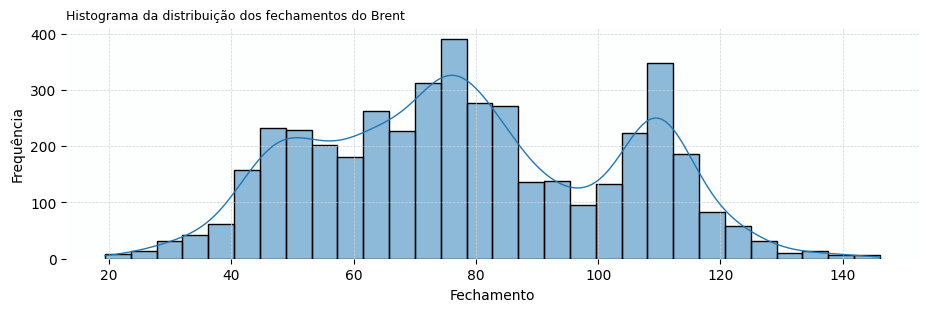

In [58]:
# @title
# Histograma do fechamento do Brent
plt.figure(figsize=(11, 3))
sns.histplot(df["fechamento"].dropna(), bins=30, kde=True)
plt.title("Histograma da distribuição dos fechamentos do Brent", loc='left', fontsize=9)
plt.xlabel("Fechamento")
plt.ylabel("Frequência")
plt.grid(True)
plt.show()


**Gráfico 2:** Histograma da distribuição de frequência dos fechamentos diários do Brent (agosto de 2009 a fevereiro de 2025)

#### 1.2.2 Fechamentos Diários: Análise Bivariada

A matriz de correlação apresentada fornece um panorama geral das relações lineares entre as diferentes variáveis do Brent. Através dela, é possível observar três pontos importantes:



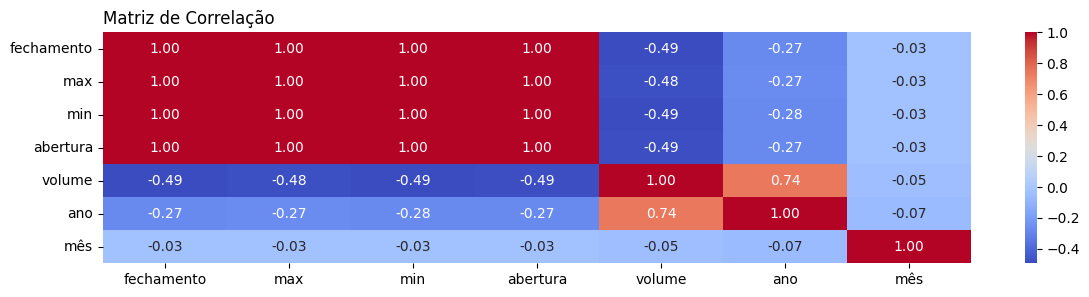

In [59]:
# @title
# Matriz de correlação com Heatmap
plt.figure(figsize=(14, 3))
correlacao_matriz = df.corr(numeric_only=True)
sns.heatmap(correlacao_matriz, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlação", loc='left')
plt.show()



1. **Fechamento e Ano:** Há uma correlação negativa fraca (-0.27) entre o preço de fechamento e o ano, indicando que, ao longo do tempo, os preços tendem a cair ligeiramente, embora sem grande significância estatística. Isso é evidenciado pelo Gráfico 2, que mostra uma leve tendência de queda nos fechamentos anuais do Brent nos últimos 18 anos. Após o pico entre 2012 e 2013, houve uma forte queda entre 2014 e 2016, seguida por uma recuperação gradual a partir de 2017. Nos anos mais recentes (2022-2025), os preços parecem ter se estabilizado em um patamar médio, sugerindo que a OPEP tem atuado para controlar a volatilidade e evitar quedas mais acentuadas.






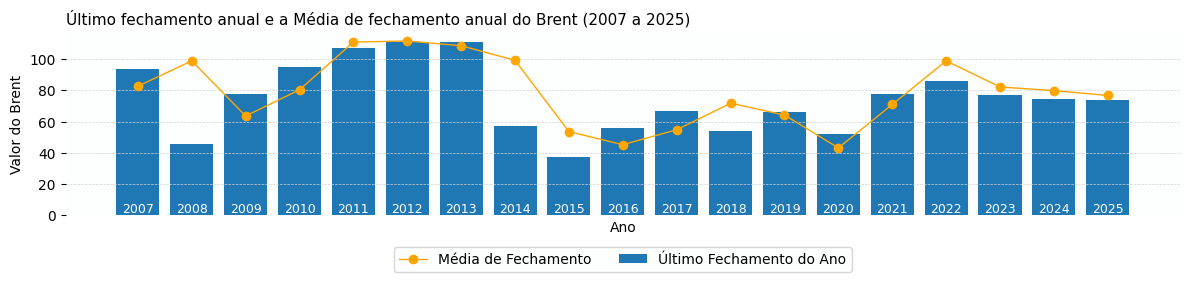

In [60]:
# @title
# Filtrando a último valor de fechamento para cada ano
ultima_pontuacao = df.groupby('ano')['fechamento'].last().reset_index()

# Calculando a média de fechamento para cada ano
media_fechamento = df.groupby('ano')['fechamento'].mean().reset_index()

# Criando o gráfico de barras
plt.figure(figsize=(12, 3))
bars = plt.bar(ultima_pontuacao['ano'], ultima_pontuacao['fechamento'], label='Último Fechamento do Ano')

# Adicionando a linha da média de fechamento
plt.plot(media_fechamento['ano'], media_fechamento['fechamento'], color='orange', marker='o', label='Média de Fechamento')

# Adicionando rótulos e título
plt.xlabel('Ano')
plt.ylabel('Valor do Brent')
plt.title('Último fechamento anual e a Média de fechamento anual do Brent (2007 a 2025)', loc='Left', fontsize=11)
plt.grid()
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=3)
# Ajustar o layout para acomodar a legenda na parte inferior
plt.subplots_adjust(bottom=0.2)  # Ajuste este valor conforme necessário


# Removendo os rótulos do eixo x
plt.xticks([])

# Adicionando os anos abaixo das barras
for bar in bars:
    yval = bar.get_height()  # Altura da barra
    plt.text(bar.get_x() + bar.get_width() / 2, -0.5,
             str(int(bar.get_x() + 1)),  # O ano está na posição x + 1 da barra
             ha='center', va='bottom', color='white', fontsize=9)  # Alinhamento horizontal e vertical

# Exibindo o gráfico
plt.tight_layout()
plt.show()


**Gráfico 3:** Evolução do Brent ao Longo dos Anos: Comparação entre a Média Anual de Fechamento e o Valor do Último Fechamento de Cada Ano (2007-2025)


2. **Volume e Ano:** Há uma correlação positiva (0.74) entre volume e ano, indicando que o volume de negociações aumentou ao longo do tempo, conforme demonstrado no Gráfico 4.

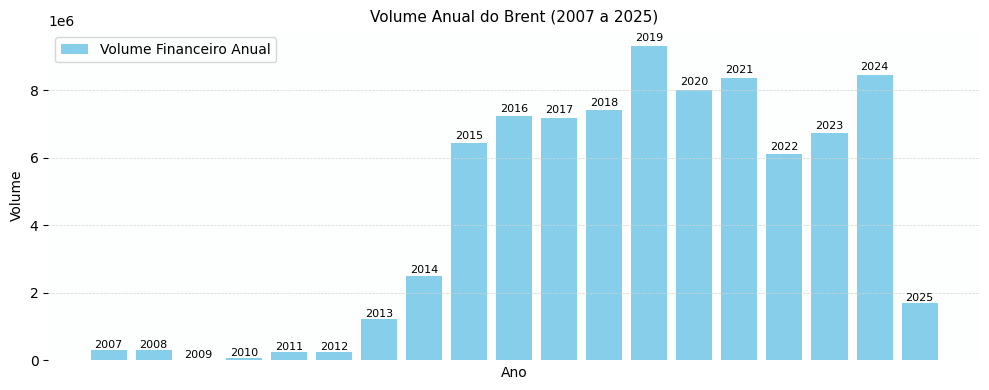

In [61]:
# @title
# Filtrando o volume financeiro total para cada ano
volume_anual = df.groupby('ano')['volume'].sum().reset_index()

# Criando o gráfico de barras
plt.figure(figsize=(10, 4))
bars = plt.bar(volume_anual['ano'], volume_anual['volume'], color='skyblue', label='Volume Financeiro Anual')

# Adicionando rótulos e título
plt.xlabel('Ano')
plt.ylabel('Volume')
plt.title('Volume Anual do Brent (2007 a 2025)', loc='center', fontsize=11)
plt.legend()
plt.grid(axis='y')

# Removendo os rótulos do eixo x
plt.xticks([])

# Adicionando os anos abaixo das barras
for bar in bars:
    yval = bar.get_height()  # Altura da barra
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01 * yval,
             str(int(bar.get_x() + 1)),  # O ano está na posição x + 1 da barra
             ha='center', va='bottom', color='black', fontsize=8)  # Alinhamento horizontal e vertical

# Exibindo o gráfico
plt.tight_layout()
plt.show()


**Gráfico 4:** Volume de ações negociadas anualmente no Brent (07/2007 - 02/2025)



3. **Mês com demais variáveis**: O mês do ano tem uma correlação muito fraca com todas as outras variáveis, indicando que a sazonalidade mensal não teve um impacto significativo no preço do Brent nos últimos 18 anos. Os gráficos 5 e 6 corroboram o fato.







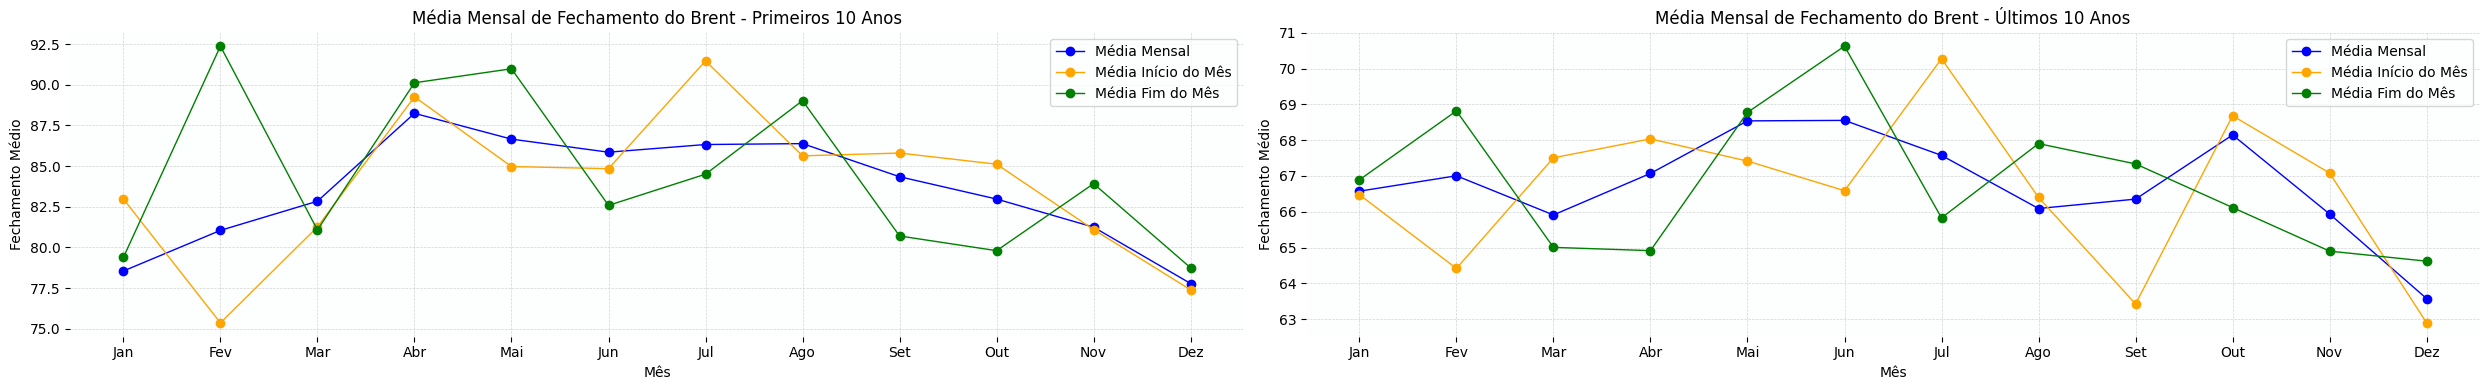

In [62]:
# @title

# Garantir que o índice do DataFrame seja datetime
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index)

# Filtrar para manter apenas a coluna 'fechamento'
df_filtered = df[['fechamento']].copy()  # Mantém a estrutura sem modificar a data

# Separar os dados nos primeiros 10 anos e nos últimos 10 anos
start_date = df_filtered.index.min()
end_date = df_filtered.index.max()

# Primeiros 10 anos
first_10_years = df_filtered[start_date:start_date.replace(year=start_date.year + 10)]
# Últimos 10 anos
last_10_years = df_filtered[end_date.replace(year=end_date.year - 10):end_date]

# Função para calcular médias mensais
def calculate_monthly_averages(data):
    data = data.copy()  # Cria uma cópia para evitar SettingWithCopyWarning
    data['month'] = data.index.month  # Extraindo o mês do índice
    start_of_month = data[data.index.day <= 5].groupby('month')['fechamento'].mean()
    end_of_month = data[data.index.day >= data.index.day.max() - 4].groupby('month')['fechamento'].mean()
    monthly_average = data.groupby('month')['fechamento'].mean()
    return monthly_average, start_of_month, end_of_month

# Calcular médias para os primeiros 10 anos
monthly_average_1, start_of_month_1, end_of_month_1 = calculate_monthly_averages(first_10_years)

# Calcular médias para os últimos 10 anos
monthly_average_2, start_of_month_2, end_of_month_2 = calculate_monthly_averages(last_10_years)

# Criar subplots
fig, axs = plt.subplots(1, 2, figsize=(25, 4))

# Gráfico para os primeiros 10 anos
axs[0].plot(monthly_average_1.index, monthly_average_1.values, marker='o', label='Média Mensal', color='blue')
axs[0].plot(start_of_month_1.index, start_of_month_1.values, marker='o', label='Média Início do Mês', color='orange')
axs[0].plot(end_of_month_1.index, end_of_month_1.values, marker='o', label='Média Fim do Mês', color='green')
axs[0].set_title('Média Mensal de Fechamento do Brent - Primeiros 10 Anos')
axs[0].set_xlabel('Mês')
axs[0].set_ylabel('Fechamento Médio')
axs[0].set_xticks(monthly_average_1.index)
axs[0].set_xticklabels(['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
axs[0].legend()
axs[0].grid(True)

# Gráfico para os últimos 10 anos
axs[1].plot(monthly_average_2.index, monthly_average_2.values, marker='o', label='Média Mensal', color='blue')
axs[1].plot(start_of_month_2.index, start_of_month_2.values, marker='o', label='Média Início do Mês', color='orange')
axs[1].plot(end_of_month_2.index, end_of_month_2.values, marker='o', label='Média Fim do Mês', color='green')
axs[1].set_title('Média Mensal de Fechamento do Brent - Últimos 10 Anos')
axs[1].set_xlabel('Mês')
axs[1].set_ylabel('Fechamento Médio')
axs[1].set_xticks(monthly_average_2.index)
axs[1].set_xticklabels(['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
axs[1].legend()
axs[1].grid(True)

# Ajustar o espaço entre os subplots
plt.subplots_adjust(hspace=2)
plt.tight_layout()
plt.show()


**Gráfico 5:** Comparação da Performance Mensal do Brent em Diferentes Décadas

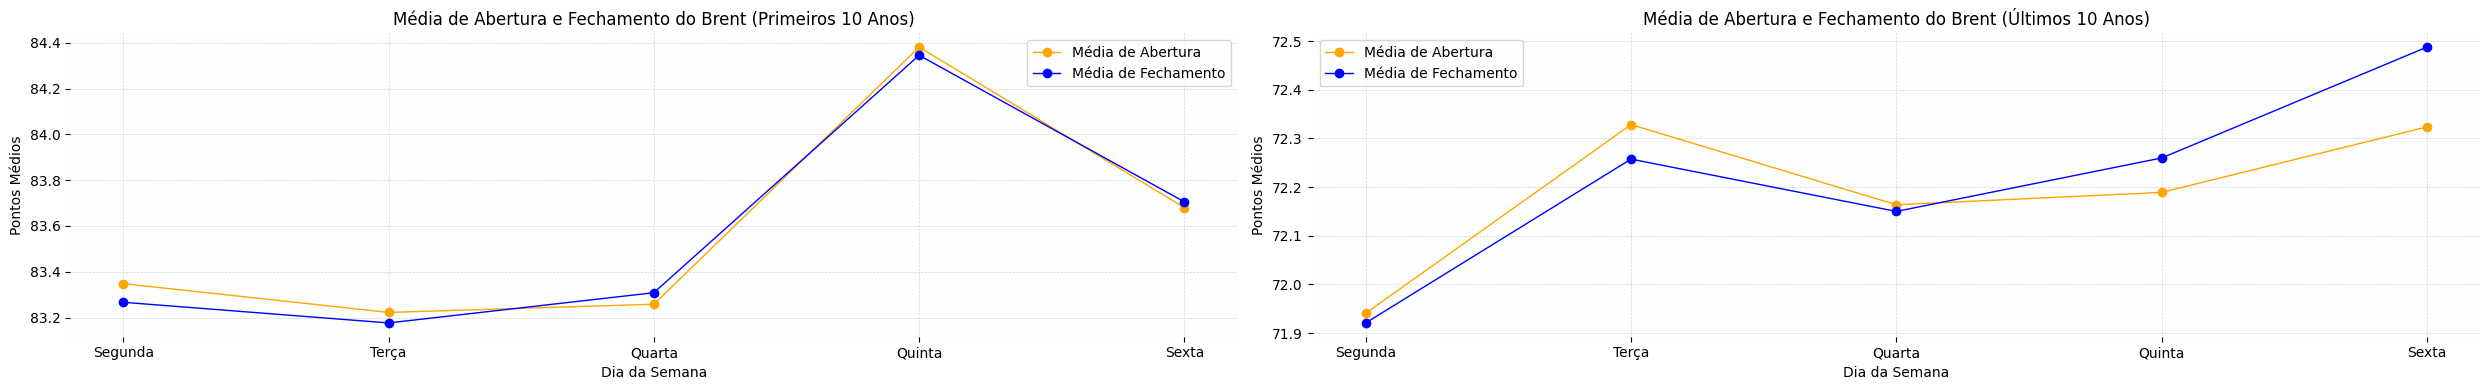

In [63]:
# @title

# Filtrar para manter apenas as colunas 'abertura' e 'fechamento'
df_filtered = df[['abertura', 'fechamento']].copy()

# Garantir que o índice é do tipo datetime (se já não for)
if not isinstance(df_filtered.index, pd.DatetimeIndex):
    df_filtered.index = pd.to_datetime(df_filtered.index)

# Criar subconjuntos para os 10 primeiros anos e os últimos 10 anos
first_10_years = df_filtered[df_filtered.index < df_filtered.index.min() + pd.DateOffset(years=10)].copy()
last_10_years = df_filtered[df_filtered.index >= df_filtered.index.min() + pd.DateOffset(years=10)].copy()

# Função para calcular a média de abertura e fechamento por dia da semana
def calculate_weekly_averages(df):
    df = df.copy()  # Garantir que estamos trabalhando com uma cópia
    df['day_of_week'] = df.index.dayofweek  # Extraindo o dia da semana do índice
    weekly_open_avg = df.groupby('day_of_week')['abertura'].mean().reset_index()
    weekly_close_avg = df.groupby('day_of_week')['fechamento'].mean().reset_index()

    # Renomear os dias da semana
    days = {0: 'Segunda', 1: 'Terça', 2: 'Quarta', 3: 'Quinta', 4: 'Sexta'}
    weekly_open_avg['day_of_week'] = weekly_open_avg['day_of_week'].replace(days)
    weekly_close_avg['day_of_week'] = weekly_close_avg['day_of_week'].replace(days)

    return weekly_open_avg, weekly_close_avg

# Calcular médias para os 10 primeiros anos
weekly_open_avg_first, weekly_close_avg_first = calculate_weekly_averages(first_10_years)

# Calcular médias para os últimos 10 anos
weekly_open_avg_last, weekly_close_avg_last = calculate_weekly_averages(last_10_years)

# Criar os gráficos
fig, axs = plt.subplots(1, 2, figsize=(25, 4))

# Gráfico para os 10 primeiros anos
axs[0].plot(weekly_open_avg_first['day_of_week'], weekly_open_avg_first['abertura'], marker='o', label='Média de Abertura', color='orange')
axs[0].plot(weekly_close_avg_first['day_of_week'], weekly_close_avg_first['fechamento'], marker='o', label='Média de Fechamento', color='blue')
axs[0].set_title('Média de Abertura e Fechamento do Brent (Primeiros 10 Anos)')
axs[0].set_xlabel('Dia da Semana')
axs[0].set_ylabel('Pontos Médios')
axs[0].legend()
axs[0].grid(True)

# Gráfico para os últimos 10 anos
axs[1].plot(weekly_open_avg_last['day_of_week'], weekly_open_avg_last['abertura'], marker='o', label='Média de Abertura', color='orange')
axs[1].plot(weekly_close_avg_last['day_of_week'], weekly_close_avg_last['fechamento'], marker='o', label='Média de Fechamento', color='blue')
axs[1].set_title('Média de Abertura e Fechamento do Brent (Últimos 10 Anos)')
axs[1].set_xlabel('Dia da Semana')
axs[1].set_ylabel('Pontos Médios')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()  # Ajustar o layout para evitar sobreposição
plt.show()


**Gráfico 6:** Comparação da Performance Semanal do Brent em Diferentes Décadas

### 1.3 Análise da Série Temporal

Após a análise dos dados, foi realizada a decomposição da série temporal do Brent e aplicado o teste de raiz unitária de Dickey-Fuller para verificar a estacionariedade. Esta etapa é crucial, pois a maioria dos modelos de aprendizado de máquina assume que os dados são estacionários. A não estacionariedade pode levar a modelos imprecisos e previsões errôneas. Caso a série não seja estacionária, transformações como a diferenciação podem ser aplicadas para torná-la estacionária.


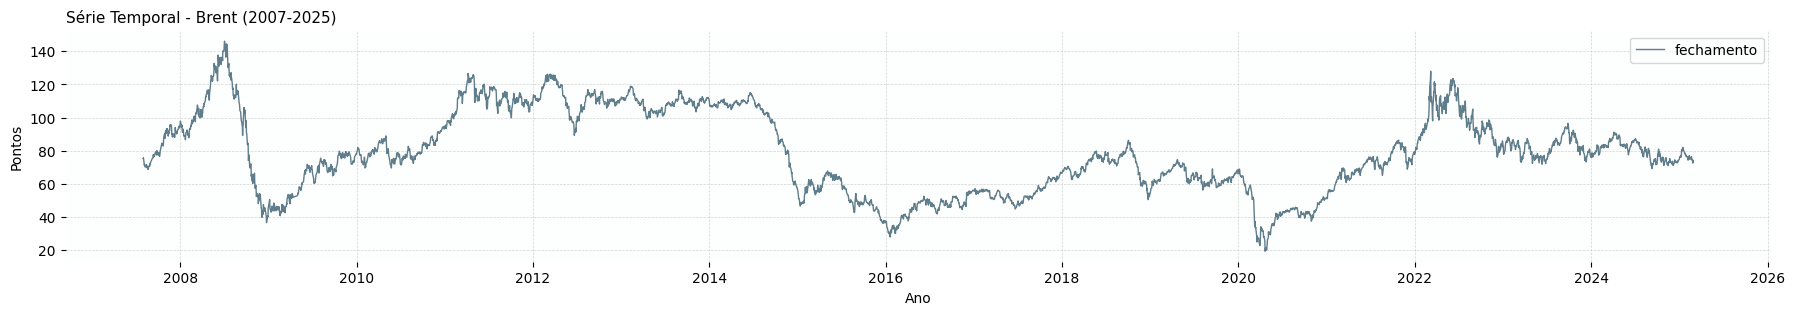

In [64]:
# @title
# Configura o tamanho do gráfico (largura, altura)
figsize = (22, 3)  # Altere para o tamanho desejado
plt.figure(figsize=figsize)

# Gráfico principal (IBOVESPA)
plt.plot(df.index, df['fechamento'], label='fechamento', color='#607d8b')

# Definir intervalo de 2 anos no eixo X
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # Define o intervalo de 2 anos
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Formato do rótulo do eixo X

# Configurações adicionais do gráfico
plt.title('Série Temporal - Brent (2007-2025)', loc="Left", fontsize=11)
plt.ylabel('Pontos')
plt.xlabel('Ano')
plt.grid(True)
plt.legend()

# Mostrar o gráfico
plt.show()


**Gráfico 7:** Série Temporal dos fechamentos diários do Brent dos últimos
18 anos.

#### 1.3.1 Decomposição da Série Temporal

Séries temporais apresentam características como tendência, sazonalidade, resíduo e autocorrelação. A decomposição da série do Brent permite isolar esses componentes, proporcionando uma análise mais precisa e detalhada desses componentes.





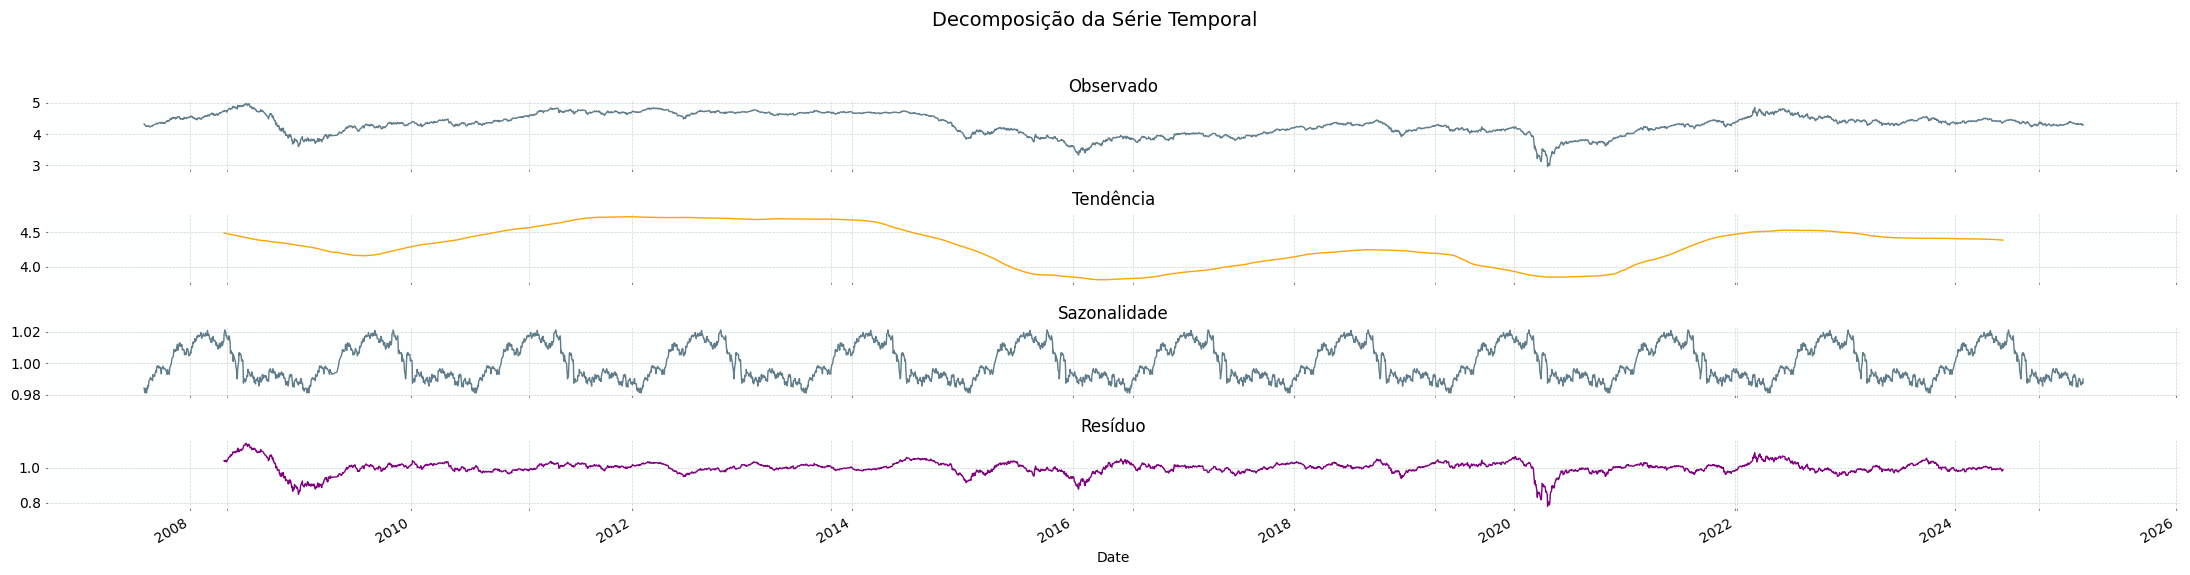

In [65]:
# @title
# Transformação logarítmica para estabilizar a variância, se os valores forem todos positivos
df["fechamento_log"] = np.log(df["fechamento"])

# Decomposição multiplicativa pode ser tentada se os componentes forem proporcionais ao nível da série
result = seasonal_decompose(df["fechamento_log"], model="multiplicative", period=365)

# Plotando o resultado
fig, axes = plt.subplots(4, 1, figsize=(22, 6), sharex=True)
result.observed.plot(ax=axes[0], title='Observado', color='#607d8b')
result.trend.plot(ax=axes[1], title='Tendência', color='orange')
result.seasonal.plot(ax=axes[2], title='Sazonalidade', color='#607d8b')
result.resid.plot(ax=axes[3], title='Resíduo', color='purple')

# Configurações de grid e linhas externas
for ax in axes:
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')
    ax.tick_params(axis='both', which='both', length=1)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_color('black')  # Linha esquerda em preto
    ax.spines['bottom'].set_color('black')  # Linha inferior em preto

# Título geral do gráfico
fig.suptitle('Decomposição da Série Temporal', fontsize=14)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Exibindo o gráfico
plt.show()


**Gráfico 8:** Decomposição da Série Temporal do fechamento do Brent em seus 4 componentes principais.

##### 1.3.1.1 Tendência

**O que é:** Refere-se ao movimento de longo prazo nos dados. É a parte da série que representa o crescimento ou declínio gradual ao longo do tempo.

**Resultado:** A série temporal do Brent não exibe uma tendência linear consistente, indicando que os valores de fechamento não seguem um padrão claro de crescimento ou declínio ao longo do tempo, apesar das variações diárias típicas do mercado. Nesse contexto, a **análise por médias móveis se mostra mais eficaz para identificar padrões e tendências na série temporal do Brent**.




*Saiba mais em detalhes ↓*


A análise de regressão linear (Gráfico 9) revela que a tendência dos fechamentos do Brent é muito sutil, com um R² de 0,0756, indicando que apenas 7,56% da variação dos preços diários é explicada pelo tempo. Esse resultado evidencia a forte influência de fatores externos e a alta volatilidade do mercado de petróleo, tornando um modelo linear simples insuficiente para capturar suas oscilações.









In [66]:
# @title
# Converte a coluna 'data' para número de dias a partir da data mínima
df['data_numerica'] = (df.index - df.index.min()).days

# Variável independente (agora numérica)
x = df[['data_numerica']].values.reshape(-1, 1)

# Variável dependente
y = df['fechamento'].values

# Cria e ajusta o modelo de regressão linear
model = LinearRegression()
model.fit(x, y)

# Faz as previsões com base nos dados de entrada
y_pred = model.predict(x)

# Calcula o coeficiente de determinação (R²)
r2 = r2_score(y, y_pred)

print(f"Coeficiente de Determinação (R²): {r2:.4f}")


Coeficiente de Determinação (R²): 0.0756


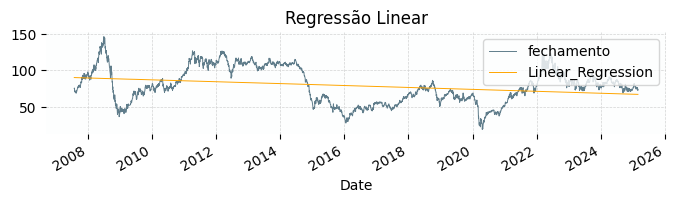

In [67]:
# @title
# Preparando os dados
X = np.arange(len(df)).reshape(-1, 1)
y = df["fechamento"].values

# Modelo de Regressão Linear
model = LinearRegression()
model.fit(X, y)
df["Linear_Regression"] = model.predict(X)

# Plotando os resultados
df[["fechamento", "Linear_Regression"]].plot(title="Regressão Linear", figsize=(8, 1.5), color=["#607d8b", "orange"], linewidth=0.7)
plt.grid(True)
plt.show()

**Gráfico 9:** Regressão Linear do fechamento diário do Brent.


Para capturar melhor essas dinâmicas, foi empregada a análise de média móvel de 80 dias. Ao considerar a média móvel, obteve-se um erro percentual absoluto médio (MAPE) de apenas 9,79%, indicando um ajuste mais preciso aos dados e uma melhor capacidade de acompanhar as flutuações de curto prazo do índice.

Vale destacar que a média móvel de 80 dias foi escolhida com base na primeira análise realizada com a janela de 200 dias, um indicador técnico amplamente utilizado no mercado financeiro.



> A média móvel é um indicador técnico amplamente utilizado na análise de mercado para suavizar os dados de preços de um ativo e identificar tendências. Ela é calculada tomando a média dos preços de um determinado período, como por exemplo, os últimos 80 dias.




In [68]:
# @title
# Calcular a média móvel de 100 dias
df['media_movel_80'] = df['fechamento'].rolling(window=80).mean()

# Ignorar os valores onde a média móvel não é definida (primeiros 99 valores)
valid_mask = df['media_movel_80'].notna()

# Calcular o Erro Quadrático Médio (EQM) e o Erro Absoluto Médio (EAM)
eqm = np.mean((df.loc[valid_mask, 'fechamento'] - df.loc[valid_mask, 'media_movel_80']) ** 2)
eam = np.mean(np.abs(df.loc[valid_mask, 'fechamento'] - df.loc[valid_mask, 'media_movel_80']))

# Calcular o MAPE
mape = np.mean(np.abs((df.loc[valid_mask, 'fechamento'] - df.loc[valid_mask, 'media_movel_80']) / df.loc[valid_mask, 'fechamento'])) * 100

# Imprimir os resultados
print(f'Erro Quadrático Médio (EQM) com janela de 80 dias: {eqm:.2f}')
print(f'Erro Absoluto Médio (EAM) com janela de 80 dias: {eam:.2f}')
print(f'Erro Percentual Absoluto Médio (MAPE) com janela de 80 dias: {mape:.2f}%')


Erro Quadrático Médio (EQM) com janela de 80 dias: 87.18
Erro Absoluto Médio (EAM) com janela de 80 dias: 6.58
Erro Percentual Absoluto Médio (MAPE) com janela de 80 dias: 9.79%


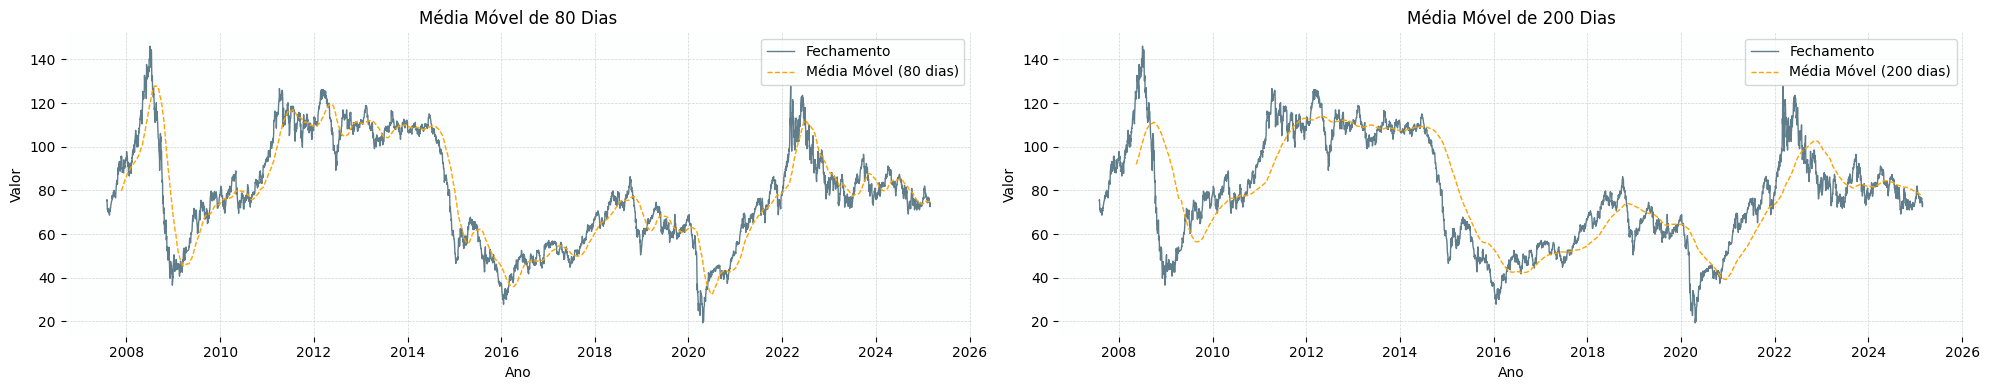

In [69]:
# @title

def plot_moving_averages(data, column, title='', ylabel='', xlabel=''):
    # Criar uma figura com dois subgráficos
    fig, ax = plt.subplots(1, 2, figsize=(20, 4))

    # Plotar a média móvel de 80 dias
    ax[0].plot(data.index, data[column], label='Fechamento', color='#607d8b')
    rolling_mean_80 = data[column].rolling(window=80).mean()
    ax[0].plot(data.index, rolling_mean_80, label='Média Móvel (80 dias)', color='orange', linestyle='--')

    # Definir intervalo de 2 anos no eixo X para o primeiro gráfico
    ax[0].xaxis.set_major_locator(mdates.YearLocator(2))
    ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax[0].set_title('Média Móvel de 80 Dias')
    ax[0].set_ylabel(ylabel)
    ax[0].set_xlabel(xlabel)
    ax[0].grid(True)
    ax[0].legend()

    # Plotar a média móvel de 200 dias
    ax[1].plot(data.index, data[column], label='Fechamento', color='#607d8b')
    rolling_mean_200 = data[column].rolling(window=200).mean()
    ax[1].plot(data.index, rolling_mean_200, label='Média Móvel (200 dias)', color='orange', linestyle='--')

    # Definir intervalo de 2 anos no eixo X para o segundo gráfico
    ax[1].xaxis.set_major_locator(mdates.YearLocator(2))
    ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax[1].set_title('Média Móvel de 200 Dias')
    ax[1].set_ylabel(ylabel)
    ax[1].set_xlabel(xlabel)
    ax[1].grid(True)
    ax[1].legend()

    # Ajustar layout
    plt.tight_layout()
    plt.show()

# Usar a função para plotar as médias móveis
plot_moving_averages(data=df, column='fechamento',
                     title='Médias Móveis do Brent',
                     ylabel='Valor', xlabel='Ano')


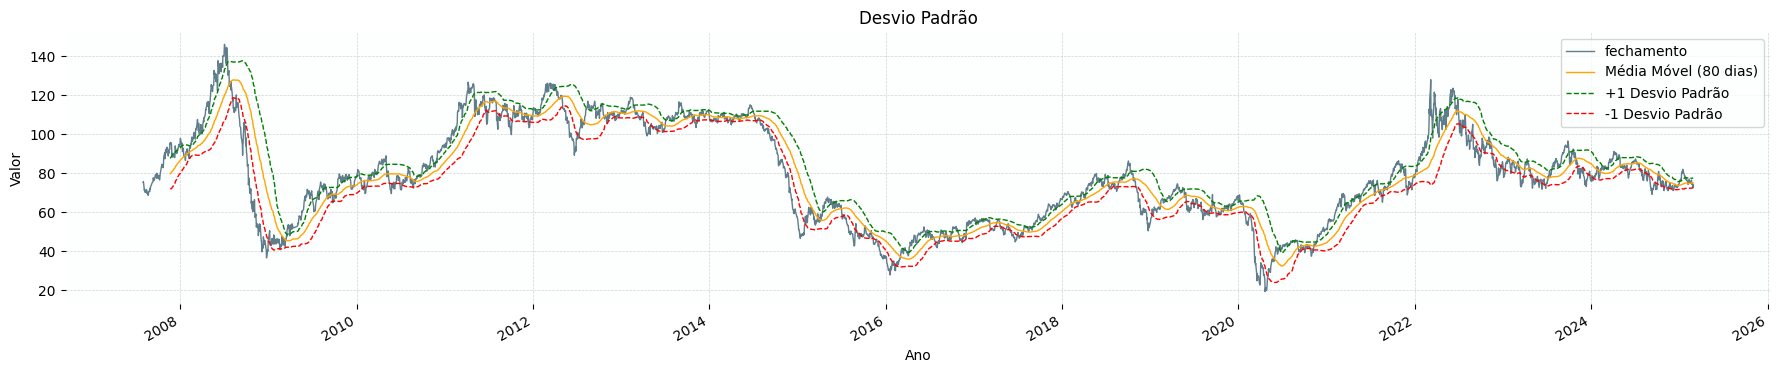

In [70]:
# @title
# Desvio padrão
def plot_series_with_events(data, column, events, bars_data=None, title='', ylabel='', xlabel=''):
    ## Gráfico Principal (Brent)
    plt.figure(figsize=(22, 4))
    ax = data[column].plot(label=column, color='#607d8b')  # Plot do fechamento

    # Cálculo da média móvel e desvio padrão
    rolling_mean = data[column].rolling(window=80).mean()
    std_dev = data[column].rolling(window=80).std()

    # Plot da média móvel e suas bandas de desvio padrão
    rolling_mean.plot(ax=ax, label='Média Móvel (80 dias)', color='orange')
    (rolling_mean + std_dev).plot(ax=ax, label='+1 Desvio Padrão', color='green', linestyle='--')
    (rolling_mean - std_dev).plot(ax=ax, label='-1 Desvio Padrão', color='red', linestyle='--')

    # Definir intervalo de 2 anos no eixo X
    plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # Define o intervalo de 2 anos
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Formato do rótulo do eixo X

    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.grid(True)
    plt.legend()
    plt.show()

# Usar a função para plotar a série do fechamento do Brent com eventos
plot_series_with_events(data=df, column='fechamento', events=eventos,
                            title='Desvio Padrão',
                            ylabel='Valor', xlabel='Ano')


**Gráfico 10:** Análise de Tendência de Longo Prazo do Brent: Comparação entre Médias Móveis de 80 e 200 Dias.

##### 1.3.1.2 Sazonalidade


**O que é:** O componente de sazonalidade mostra padrões repetitivos em intervalos regulares.

**Resultado:** A complexidade da sazonalidade do Brent reside na variação de seus ciclos, tanto em duração quanto em intensidade. Essa oscilação reforça a influência de fatores macroeconômicos, geopolíticos e de oferta/demanda, o que dificulta a decomposição sazonal.




*Saiba mais em detalhes ↓*


A função seasonal_decompose foi utilizada para entender a sazonalidade da série. Foram analisados 4 diferentes periodos na busca por uma sazonalidade:


* **180 dias (6 meses):** Apresenta picos regulares seguidos de quedas, sugerindo ciclos curtos de alta demanda seguidos por correções. Possivelmente ligados a estoques e sazonalidade industrial.

* **365 dias (1 ano)**: Começa subindo no início do ano e desacelera ao longo do período. Reflete padrões anuais de consumo, como maior demanda no inverno e ajustes da OPEP.

* **540 dias (1,5 anos):** Mostra tendências menos simétricas, com oscilações mais suaves e ciclos de alta seguidos por quedas moderadas. Pode indicar realinhamentos de oferta e demanda globais.

* **730 dias (2 anos):** Mostra ciclos de alta seguidos por períodos prolongados de estabilização ou queda. Indica movimentos estruturais do mercado, como choques de oferta, crises econômicas e mudanças na geopolítica do petróleo.



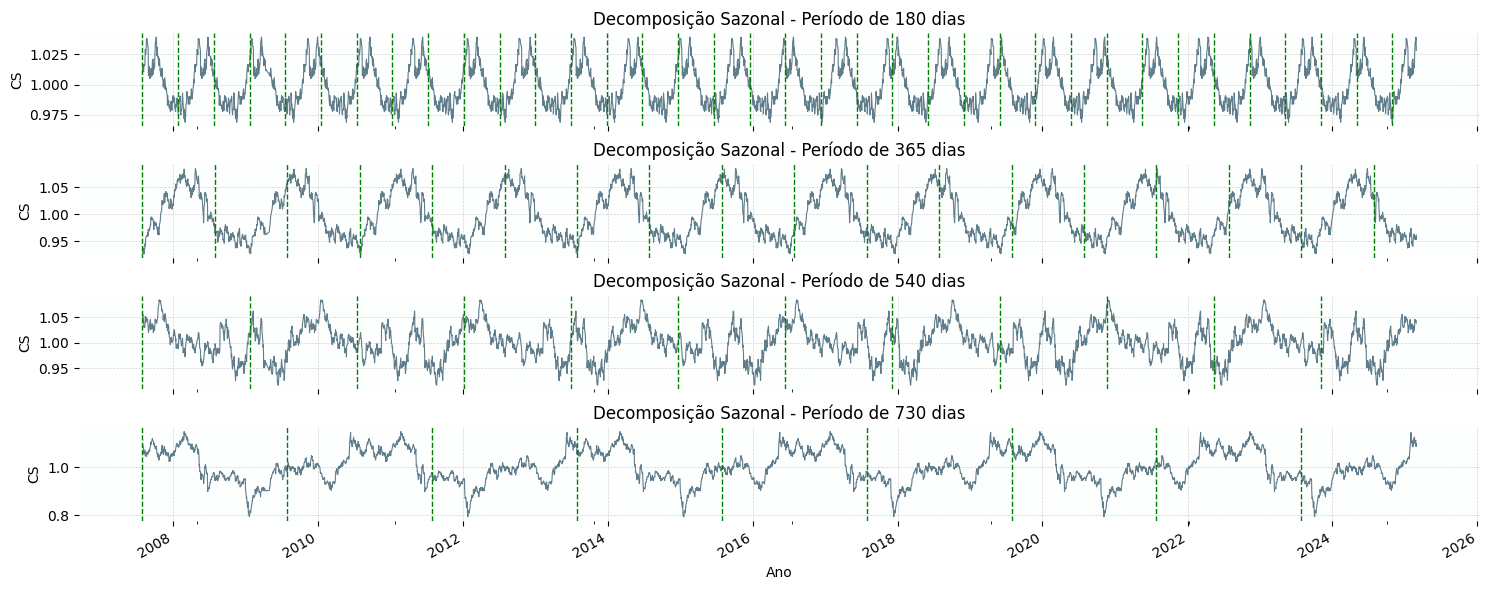

In [71]:
# @title

# Lista de períodos a serem analisados
periods = [180, 365,540, 730]
titles = ["180 dias", "365 dias","540 dias", "730 dias"]

# Criar figura com três subgráficos
fig, axes = plt.subplots(4, 1, figsize=(15, 6), sharex=True)

for i, period in enumerate(periods):
    # Decomposição sazonal
    result = seasonal_decompose(df["fechamento"], model="multiplicative", period=period)
    df_seasonal = result.seasonal.to_frame(name="seasonal")
    df_seasonal = df_seasonal[df_seasonal.index >= "2007-01-01"]  # Filtrar a partir de 2007

    # Plotar o gráfico
    ax = axes[i]
    df_seasonal.plot(ax=ax, color="#607d8b", linewidth=0.8, legend=False)

    # Adicionar linhas vermelhas a cada período
    start_date = df_seasonal.index.min()
    end_date = df_seasonal.index.max()
    periodic_ticks = pd.date_range(start=start_date, end=end_date, freq=f'{period}D')
    for date in periodic_ticks:
        ax.axvline(date, color='green', linestyle='--', linewidth=1)

    ax.set_title(f"Decomposição Sazonal - Período de {titles[i]}")
    ax.set_ylabel("CS")
    ax.grid(True)

plt.xlabel("Ano")
plt.tight_layout()
plt.show()





**Gráfico 11:** O gráfico mostra o Componente Sazonal (CS) de uma série temporal do fechamento do Brent, usando uma decomposição sazonal multiplicativa com um período de 365, 540 e 730 dias.

##### 1.3.1.3 Resíduo

**O que é:** O resíduo representa as variações não explicadas pela tendência e pela sazonalidade, ou seja, os movimentos aleatórios e imprevisíveis do mercado.

**Resultado:** A análise dos resíduos corrobora a observação inicial de que os movimentos aleatórios do Brent estão frequentemente relacionados a  fatores macroeconômicos, geopolíticos e oferta/demanda.






*Saiba mais em detalhes ↓*

A análise dos resíduos do Brent revela picos e vales ligados a períodos de alta volatilidade, geralmente impulsionados por eventos que afetam abruptamente o mercado.

A crise financeira de 2008, por exemplo, desencadeou quedas acentuadas nos preços. Já os cortes de produção acordados pela OPEP no final de 2016 impulsionaram os preços entre 2017 e 2018. A pandemia de COVID-19 em 2020 causou uma queda brusca, enquanto a guerra na Ucrânia em 2022 exerceu pressão de alta sobre os preços.



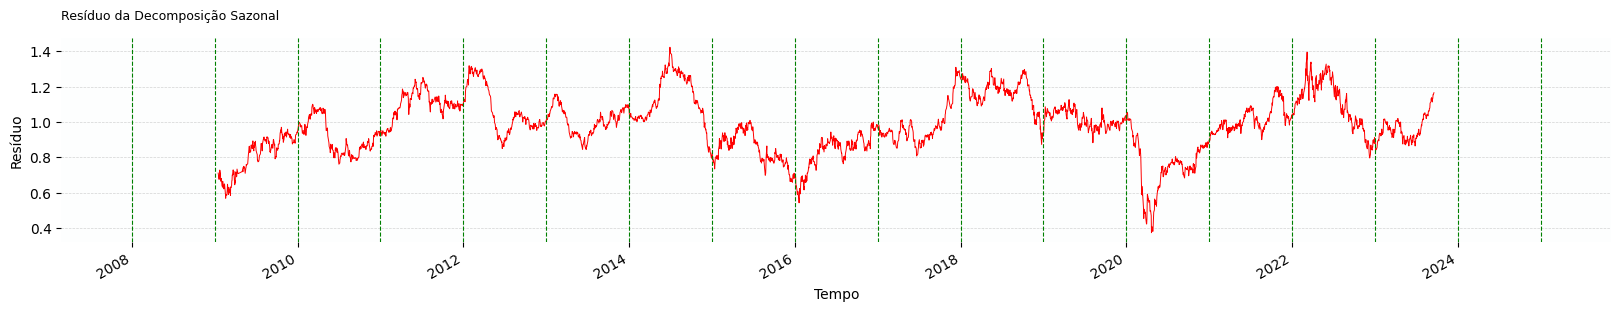

In [72]:
# @title
# Filtrar os resíduos a partir de 2007
resid_2007 = result.resid[result.resid.index >= "2007-01-01"]

# Criar a figura
fig, ax = plt.subplots(figsize=(20, 3))
resid_2007.plot(ax=ax, color="red", linewidth=0.7)
ax.set_title("Resíduo da Decomposição Sazonal", fontsize=9, loc='left', y=1.05)
ax.set_ylabel("Resíduo")
ax.set_xlabel("Tempo")

# Número total de pontos de dados (dias) no resíduo filtrado
total_dias = len(resid_2007)

# Criar os anos para marcação
anos = pd.date_range(start=resid_2007.index.min(), end=resid_2007.index.max(), freq='YS')

# Adicionar linhas verticais para identificar os anos
for ano in anos:
    ax.axvline(x=ano, color='green', linestyle='--', linewidth=0.8)

plt.grid(True)
plt.show()



**Gráfico 12:** Resíduo da Série Temporal do Brent (2007 - 2025)

#### 1.3.2 Decomposição Autoregressiva

Após analisar a tendência, sazonalidade e resíduos da série temporal do Brent, realizou-se o estudo de autocorrelação para embasar a modelagem de machine learning.

**Resultado:** Ao final do estudo foi observado que a série temporal do Brent revelou um ACF alto/persistente (227 lag)e PACF com corte rápido (2), o que é característico de séries com forte componente autorregressiva, possivelmente integradas.  É comum em séries de preços financeiros e sugere que, embora a história distante importa para o comportamento geral da série, para fins de previsão imediata, é necessário considerar os dois dias anteriores.

Essa combinação exige um modelo de previsão que capture tanto a dependência de longo prazo quanto os efeitos de curto prazo. Modelos ARIMA, por sua flexibilidade, são os mais adequados para ajustar essa série, permitindo capturar essas duas dinâmicas.








*Saiba mais em detalhes ↓*

##### 1.3.2.1 Autocorrelação



**O que é:** A autocorrelação é um fenômeno estatístico que mede a dependência entre os valores passados e presentes de uma série temporal. Uma alta autocorrelação significa que os valores anteriores influenciam significativamente os valores futuros. No cenário do Brent indica que os valores de um dia podem influenciar os dias seguintes, criando padrões. No entanto, é importante lembrar que o ACF mostra apenas padrões passados e não garante o comportamento futuro do mercado.

**Resultado:** A série do Brent apresenta uma autocorrelação que diminui à medida que os lags aumentam, sugerindo que a influência dos valores passados na previsão dos valores futuros diminui com o tempo.







*Saiba mais em detalhes ↓*

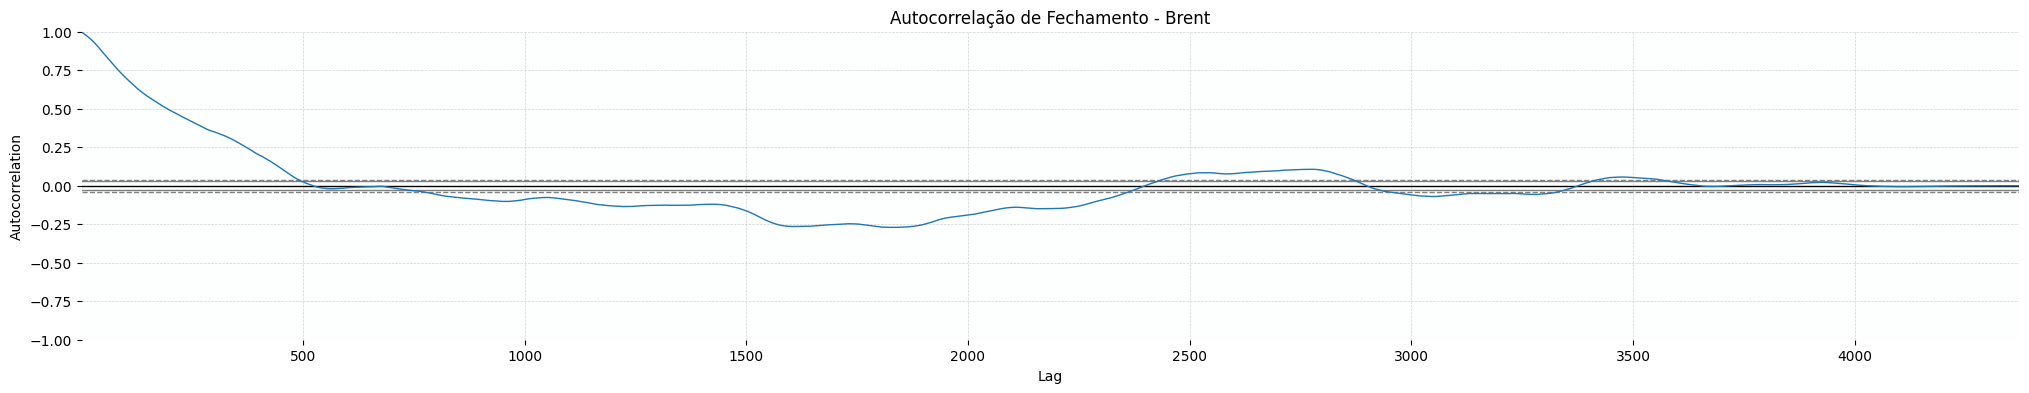

In [73]:
# @title
# Configurar o tamanho do gráfico
plt.figure(figsize=(25, 4))  # Altere os valores para ajustar a largura e a altura do gráfico

# Plotar a autocorrelação
autocorrelation_plot(df['fechamento'])
plt.title('Autocorrelação de Fechamento - Brent')
plt.show()


**Gráfico 13:** Autocorrelação da Série Temporal do Brent (2007 - 2025)

O gráfico de autocorrelação do Brent (Gráfico 13) mostra uma forte correlação nos primeiros 500 dias, indicando que os preços mantêm uma "memória" de cerca de dois anos de negociação. Após esse período, a correlação diminui gradualmente e oscila próximo de zero, sugerindo que o impacto dos eventos passados enfraquece com o tempo. Entre os lags 1500-2000 (cerca de 6-8 anos), observa-se uma autocorrelação negativa, o que pode refletir ciclos de longo prazo ou reversões de tendência no mercado de petróleo. Com o tempo, a autocorrelação tende a zero, indicando que eventos muito antigos deixam de influenciar os preços atuais.


 Esse padrão sugere que modelos preditivos podem se beneficiar de dados históricos de até 500 dias, enquanto períodos mais longos oferecem retornos decrescentes.

##### 1.3.2.2 ACF

**O que é:** O ACF, ou Função de Autocorrelação (Autocorrelation Function), é uma ferramenta usada para medir quão forte é a autocorrelação nos dados ao longo de diferentes intervalos de tempo. Permitindo, assim, a identificação de padrões repetitivos nos dados, como tendências de alta ou baixa.

**Resultado:** A série apresenta ACF alto e de decaimento lento, indicando uma forte persistência na série temporal, onde valores passados continuam influenciando os valores atuais por longos períodos (até 227 lags). Isso sugere memória longa e possível não-estacionariedade na série.

Por fim, através desta análise fica claro que modelos de aprendizado de curto prazo podem não ser adequados. É preciso utilizar modelos que capturam a sazonalidade de longo prazo, como SARIMA. Assim como realizar a transformação da série (diferenciação) para obter um resultado melhor com o modelo de aprendizado.






*Saiba mais em detalhes ↓*

Os coeficientes ACF interceptam o limiar no lag 227


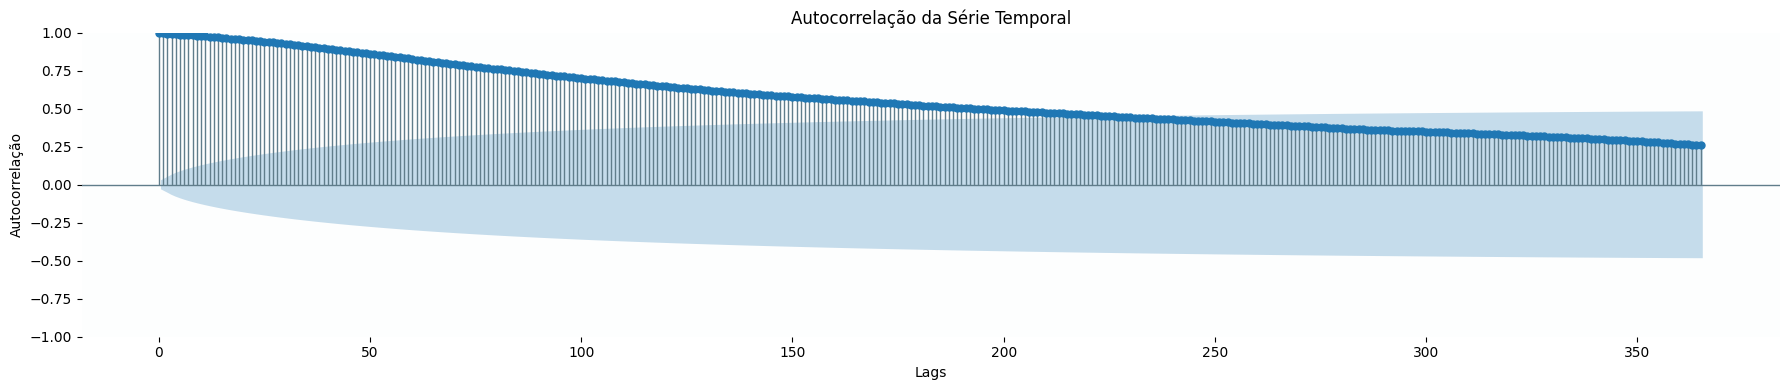

In [74]:
# @title
# acf
from statsmodels.graphics.tsaplots import plot_acf as _plot_acf

def plot_acf(df, lags=365, title="Autocorrelação da Série Temporal"):

    fig, ax = plt.subplots(figsize=(18, 4))
    # Get the ACF values and confidence intervals
    _plot_acf(df, lags=lags, ax=ax, alpha=0.05)
    ax.set_title(title)
    ax.set_xlabel("Lags")
    ax.set_ylabel("Autocorrelação")
    fig.set_tight_layout(True)

    #AONDE ESTA MEU PONTO DE CORTE (ACF)
    acf_x = sm.tsa.acf(df, alpha=0.05, nlags=500)
    acf, ci = acf_x[:2]
    intercept_point = np.where(abs(acf) < (ci[:, 1] - acf))
    if intercept_point[0].size > 0:
        print(
            f"Os coeficientes ACF interceptam o limiar no lag {intercept_point[0][0]}"
        )
    else:
        print("Os coeficientes ACF não interceptam o limiar")

plot_acf(df['fechamento'])

**Gráfico 14:** Autocorrelação da Série Temporal do Brent com lag 227 (2007 - 2025)

Analisando o gráfico de autocorrelação do Brent, nota-se que os coeficientes ACF interceptam o limiar apenas no lag 227, indicando uma memória longa na série temporal. O decaimento extremamente lento da autocorrelação sugere forte não-estacionariedade nos preços, provavelmente com presença de raiz unitária. Isso demonstra que o petróleo Brent mantém forte inércia e previsibilidade por quase um ano de negociação.

Este comportamento exige modelos específicos como SARIMA para capturar adequadamente a dinâmica dos preços. Para o mercado, isso indica que tendências nos preços do Brent tendem a persistir por longos períodos antes de reverterem.


##### 1.3.2.3 PACF

**O que é:** O PACF, ou Função de Autocorrelação Parcial, mede a autocorrelação entre uma série temporal e suas defasagens, ignorando as influências das defasagens intermediárias. Isso ajuda a entender a relação direta entre os dados e a definir a ordem dos modelos autoregressivos (AR).

**Resultado:** Os coeficientes PACF interceptam o limiar no lag 2, isto é, os últimos 2 dias são cruciais para prever o valor atual do Brent, e um modelo AR(2) é uma boa opção para capturar essa dinâmica.

Isto é, embora exista o ACF revele uma influência persistente, ela é principalmente mediada através das observações mais recentes. Em termos práticos, significa que os efeitos dos dias mais distantes já estão contidos ou "canalizados" através dos dois dias imediatamente anteriores.

Os coeficientes PACF interceptam o limiar no lag 2


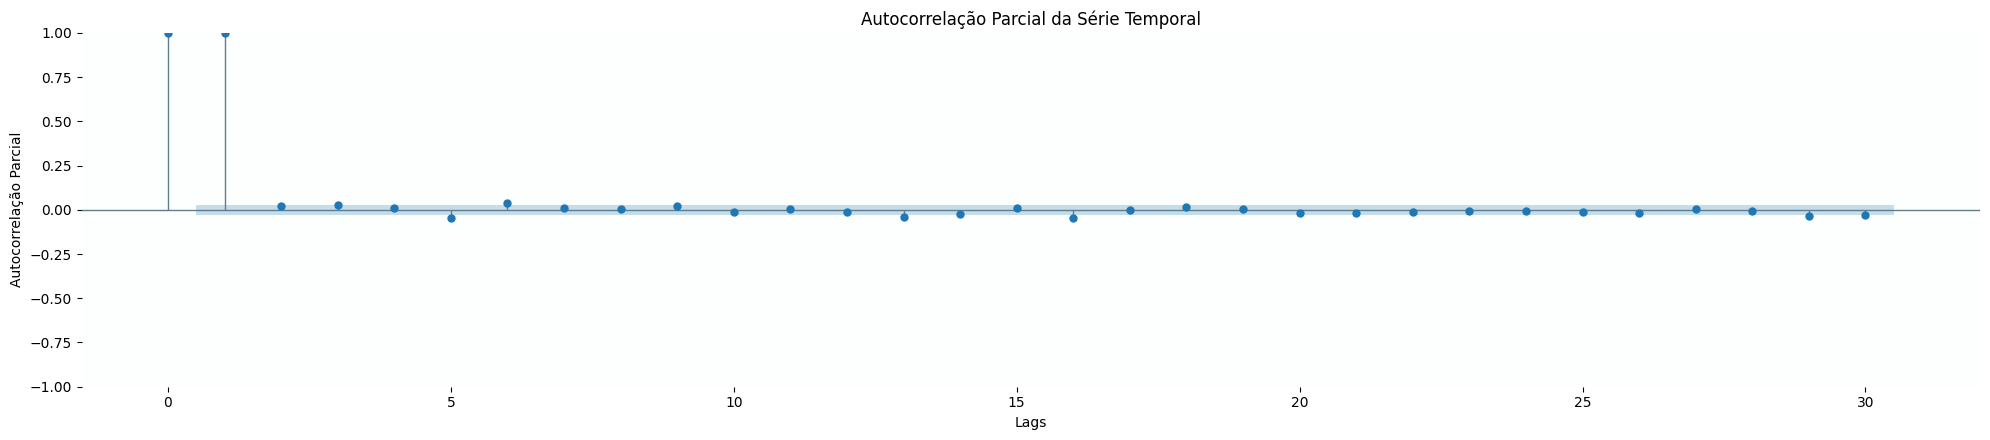

In [75]:
# @title
# acf
from statsmodels.graphics.tsaplots import plot_pacf as _plot_pacf


def plot_pacf(df, lags=30, title="Autocorrelação Parcial da Série Temporal"):

    fig, ax = plt.subplots(figsize=(20, 4.5))
    # Get the ACF values and confidence intervals
    _plot_pacf(df, lags=lags, ax=ax, alpha=0.05)
    ax.set_title(title)
    ax.set_xlabel("Lags")
    ax.set_ylabel("Autocorrelação Parcial")
    fig.set_tight_layout(True)

    acf_x = sm.tsa.pacf(df, alpha=0.05, nlags=30)
    # acf_x = sm.tsa.pacf(df, alpha=0.05, nlags=3) #com 3 dias já é possivel identificar o PACF
    acf, ci = acf_x[:2]
    intercept_point = np.where(abs(acf) < (ci[:, 1] - acf))
    if intercept_point[0].size > 0:
        print(
            f"Os coeficientes PACF interceptam o limiar no lag {intercept_point[0][0]}"
        )
    else:
        print("Os coeficientes PACF não interceptam o limiar")

plot_pacf(df["fechamento"])

**Gráfico 15:** Autocorrelação Parcial da Série Temporal do Brent com lag 2 (2007 - 2025)

### 1.4 Estacionariedade


**O que é:** Uma série temporal é considerada estacionária quando possui   propriedade   estatísticas  razoavelmente estáveis ao longo do tempo (no que se diz sobre média e à variância).

**Resultado:** Ao longo da Análise Exploratória dos Dados a série temporal apresentou caracteristicas não estacionarárias. O teste ADF (valor-p = 0,15) confirmou essa característica, evidenciando a necessidade de transformação (diferenciação) da série para garantir a estacionariedade e permitir uma modelagem mais precisa.

In [76]:
# @title
# Executar o teste de Dickey-Fuller Aumentado (ADF)
adf_result = sm.tsa.adfuller(df["fechamento"])

# Organizar os resultados em um DataFrame
adf_table = pd.DataFrame({
    "Métrica": ["Estatística ADF", "Valor-p", "Valor Crítico 1%", "Valor Crítico 5%", "Valor Crítico 10%"],
    "Valor": [round(adf_result[0], 2), round(adf_result[1], 2),
              round(adf_result[4]['1%'], 2), round(adf_result[4]['5%'], 2),
              round(adf_result[4]['10%'], 2)]
})

# Exibir a tabela formatada
print(adf_table.to_string(index=False))

# Verificar se a série é estacionária
if adf_result[1] < 0.05:
    print("\nA série temporal é estacionária")
else:
    print("\nA série temporal não é estacionária")


          Métrica  Valor
  Estatística ADF  -2.36
          Valor-p   0.15
 Valor Crítico 1%  -3.43
 Valor Crítico 5%  -2.86
Valor Crítico 10%  -2.57

A série temporal não é estacionária


## 2. Preparação dos Dados para Modelagem


### 2.1 Diferenciação para estacionariedade

A fim de garantir a qualidade das análises e previsões, a série temporal foi transformada em estacionária por meio da diferenciação. Essa etapa é fundamental para remover componentes não estacionários, como tendências e sazonalidades, que podem prejudicar a modelagem.

In [77]:
# @title
# Diferenciar a série uma vez e remover valores NaN
df_diff = df["fechamento"].diff().dropna()

# Executar o teste de Dickey-Fuller Aumentado (ADF) na série diferenciada
adf_result = sm.tsa.adfuller(df_diff)

# Organizar os resultados em um DataFrame
adf_table = pd.DataFrame({
    "Métrica": ["Estatística ADF", "Valor-p", "Valor Crítico 1%", "Valor Crítico 5%", "Valor Crítico 10%"],
    "Valor": [round(adf_result[0], 2), round(adf_result[1], 2),
              round(adf_result[4]['1%'], 2), round(adf_result[4]['5%'], 2),
              round(adf_result[4]['10%'], 2)]
})

# Exibir a tabela formatada
print(adf_table.to_string(index=False))

# Verificar se a série diferenciada é estacionária
if adf_result[1] < 0.05:
    print("\nA série temporal diferenciada é estacionária")
else:
    print("\nA série temporal diferenciada não é estacionária")


          Métrica  Valor
  Estatística ADF -15.76
          Valor-p   0.00
 Valor Crítico 1%  -3.43
 Valor Crítico 5%  -2.86
Valor Crítico 10%  -2.57

A série temporal diferenciada é estacionária


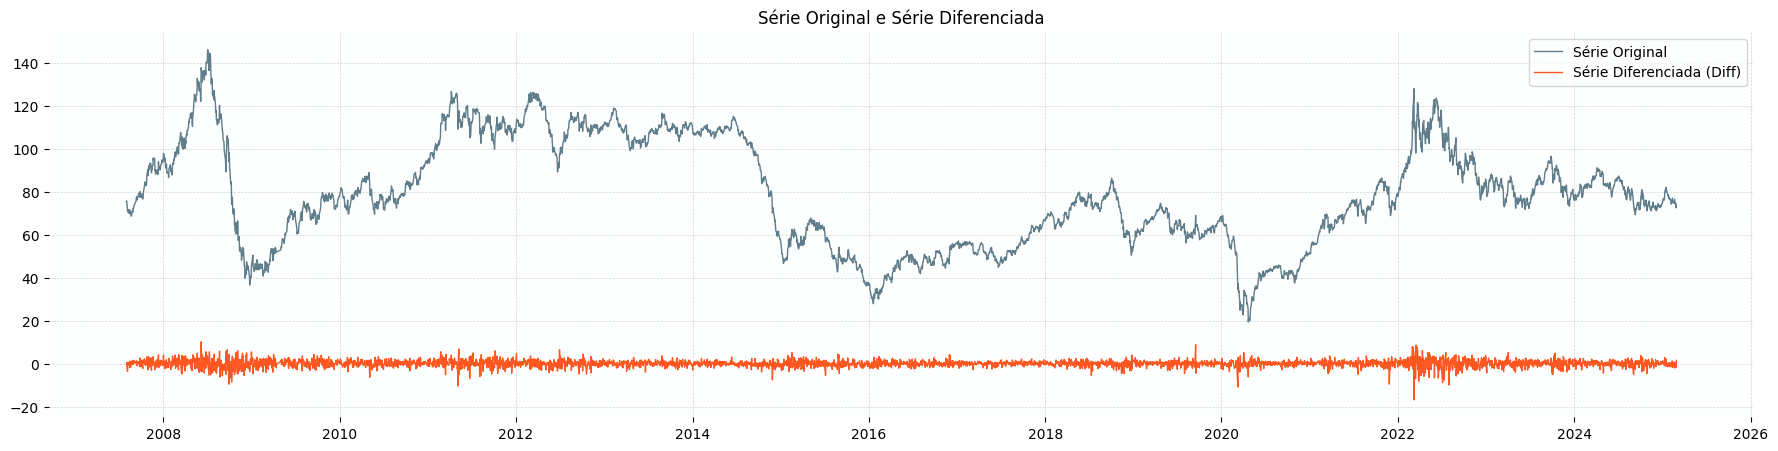

In [78]:
# @title
import matplotlib.pyplot as plt

# Série original
fig, ax = plt.subplots(figsize=(22, 5))

# Plotar a série original
ax.plot(df["fechamento"], color='#607d8b', label="Série Original")

# Aplicar a transformação de diferença (diff)
df_diff = df["fechamento"].diff().dropna()

# Plotar a série diferenciada no mesmo gráfico
ax.plot(df_diff, color='#ff5722', label="Série Diferenciada (Diff)")

# Adicionar título e legenda
ax.set_title("Série Original e Série Diferenciada")
ax.legend()

# Exibir o gráfico
plt.grid(True)
plt.show()


**Gráfico 16:** Transformação para Estacionariedade: Comparação entre a série original não estacionária e a série diferenciada, estacionária, obtida por meio da primeira diferença.

A estacionariedade da série, confirmada pelo teste ADF e Gráfico 16, permite dar prosseguimento à próxima etapa que consiste em identificar os parâmetros mais adequados para os modelo, a fim de capturar a dinâmica da série e gerar previsões precisas.

### 2.2 Parâmetros para Modelagem

#### Coeficientes de autoregressão (ARIMA)

**Resultado foi obtido:** (2, 1, 227)

Uma vez que a série temporal é estacionaria é possível obter os coeficientes de regressão : p, d e q. Esses coeficientes são essenciais para construir um modelo ARIMA adequado, que consiga capturar as dinâmicas da série temporal de forma eficaz, permitindo previsões mais precisas.


* ACF é usada para determinar o parâmetro 𝑞, identificando a ordem da parte de médias móveis do modelo.
* PACF é usada para determinar o parâmetro 𝑝, identificando a ordem da parte autoregressiva do modelo.
*𝑑 foi previamente identificado como o número de diferenciações necessárias para tornar a série estacionária.



In [79]:
# @title
acf_x = sm.tsa.acf(df["fechamento"], alpha=0.05, nlags=500) #consigo apartir de 227
acf, ci = acf_x[:2]
# identificação do q pelo ponto de interceptação ao 95% com o acf
q = np.where(abs(acf) < (ci[:, 1] - acf))[0][0]

pacf_x = sm.tsa.pacf(df["fechamento"], alpha=0.05, nlags=30) #apartir de 2 dias
pacf, ci = pacf_x[:2]
# identificação do p pelo ponto de interceptação ao 95% com o pacf
p = np.where(abs(pacf) < (ci[:, 1] - pacf))[0][0]

d = 1  # apenas 1 diferenciação foi necessária para tornar a série estacionária

#parametros do modelo ARIMA (autorregressivel com a média móvel)

print("Valor de p:", p)
print("Valor de d:", d)
print("Valor de q:", q)


Valor de p: 2
Valor de d: 1
Valor de q: 227


#### Determinando os parâmetros de sazonalidade (SARIMA)

**Melhor modelo:** ARIMA(3,1,2)(1,0,0)[12]


Para determinar os parâmetros de sazonalidade, foi utilizada a função model = pm.auto_arima. O resultado obtido foi:

**Melhor modelo:** SARIMA(3,1,2)(1,0,0,12)[12]

Esse modelo (1, 0, 0, 12) indica um ciclo sazonal de 12 meses, mas não leva em conta a autocorrelação ou a média móvel sazonal. Essa configuração sugere que a série temporal apresenta um padrão sazonal regular, sem complexidades adicionais.


In [80]:
# @title
model = pm.auto_arima(
    df["fechamento"],
    seasonal=True,
    m=12,
    stepwise=True,
    trace=True,
)

# Summary of the model's detected parameters
print(model.summary())

# Detected seasonal order
seasonal_order = model.seasonal_order
print(f"Detected Seasonal Order: {seasonal_order}")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=16888.320, Time=25.47 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=16896.591, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=16890.503, Time=0.86 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=16890.526, Time=1.35 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=16894.591, Time=0.08 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=16887.766, Time=7.07 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=16890.507, Time=3.11 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=16888.797, Time=18.47 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=16887.590, Time=11.65 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=16888.663, Time=22.98 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=16890.290, Time=34.90 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=16894.303, Time=2.09 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=16890.267, Time=4.05 sec
 ARIMA(3,1,2)(1,0,0)[12] intercept   : AIC=16877.571, Time=6.83 sec


### 2.3 Dividindo os Dados em Treino e Teste
Para avaliar a performance do modelo, os dados foram divididos em conjuntos de treinamento (70%) e teste (30%). O modelo foi treinado com o conjunto de treino e, em seguida, avaliado com o conjunto de teste.

In [81]:
# @title
# Dividindo em treino e teste
train_size = int(df.shape[0] * 0.7)  # 70% dos dados para treino
train, test = df[:train_size], df[train_size:]

# Preparação dos dados para XGBoost (usando a data do índice)
def create_features(modelo_df):
    modelo_df = modelo_df.copy()  # Evitar alterações na versão original
    modelo_df["year"] = modelo_df.index.year
    modelo_df["month"] = modelo_df.index.month
    modelo_df["day"] = modelo_df.index.day
    modelo_df["dayofweek"] = modelo_df.index.dayofweek
    return modelo_df

train = create_features(train)
test = create_features(test)

FEATURES = ["year", "month", "day", "dayofweek", "abertura"]  # Inclua média móvel para aumentar a precisão
TARGET = "fechamento"


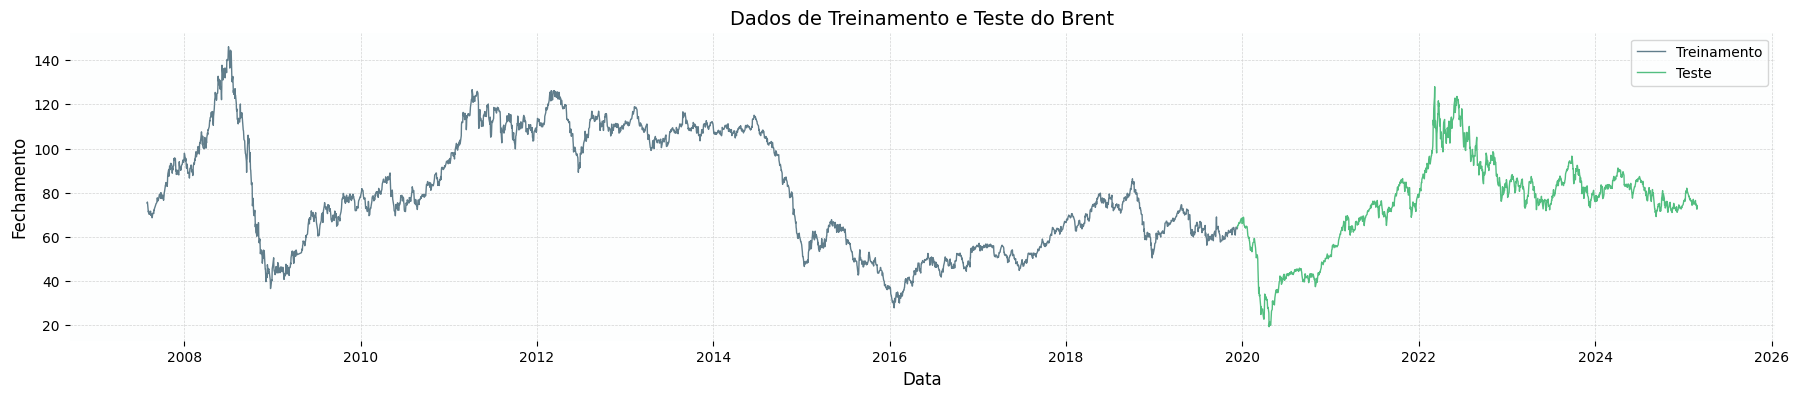

In [82]:
# @title
# Configurações do gráfico
plt.figure(figsize=(22, 4))
plt.gca().set_facecolor('#fdfefe')
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)

# Plotando os dados de treino e teste
plt.plot(train.index, train['fechamento'], color='#607d8b', linewidth=1, label='Treinamento')
plt.plot(test.index, test['fechamento'], color='#52be80', linewidth=1, label='Teste')

# Configurações dos rótulos e título
plt.xlabel('Data', fontsize=12)
plt.ylabel('Fechamento', fontsize=12)
plt.title('Dados de Treinamento e Teste do Brent', fontsize=14)
plt.legend()

# Exibindo o gráfico
plt.show()


**Gráfico 17:** Divisão dos Dados do Brent: Treino e Teste.

## 3. Modelagem

Após a preparação dos dados, será realizada a escolha do modelo de previsão, que é crucial para obter previsões precisas. Três modelos de aprendizado serão testados com dados de treinamento e teste, e o desempenho será avaliado pelo MAPE (Mean Absolute Percentage Error) para identificar o ajuste mais adequado aos dados do Brent.


> O MAPE mostra o quanto, em média, as previsões de um modelo estão erradas em relação aos valores reais, expressando esse erro em porcentagem. Logo, **quanto menor o MAPE melhor**.



### 3.1 Modelo XGBoost

**O que é:** O XGBoost é um algoritmo de machine learning baseado em boosting de árvores de decisão, conhecido por seu alto desempenho, mas suscetível a overfitting e menos adequado para séries temporais que requerem médias móveis, como em séries temporais financeiras.

**Resultado:** XGBoost teve um MAPE de 2.64%.


**Observações:** Este modelo demonstra excelente precisão (97,36%) na previsão dos preços do Brent. Observa-se um ajuste muito próximo entre as linhas de previsão (laranja) e dados reais (azul) ao longo de todo o período 2020-2025. O modelo captura com eficiência tanto os picos quanto as quedas bruscas, incluindo a queda histórica durante a pandemia em 2020. É notável como as previsões acompanham precisamente até mesmo as pequenas flutuações diárias.

In [83]:
# @title
# Modelo XGBoost
X_train, y_train = train[FEATURES], train[TARGET]
X_test, y_test = test[FEATURES], test[TARGET]

reg = xgb.XGBRegressor(objective="reg:squarederror")
reg.fit(X_train, y_train)

# Avaliação XGBoost
preds = reg.predict(X_test)
metrics_xgb = calculate_metrics(y_test, preds)
print("XGBoost Metrics:")
print_metrics(metrics_xgb)

XGBoost Metrics:
MAE: 1.5832083125812249
MSE: 5.4108420147725536
MAPE: 2.64 %


In [84]:
print("Acurácia:", f"{100 - 2.64: .2f}%")

Acurácia:  97.36%


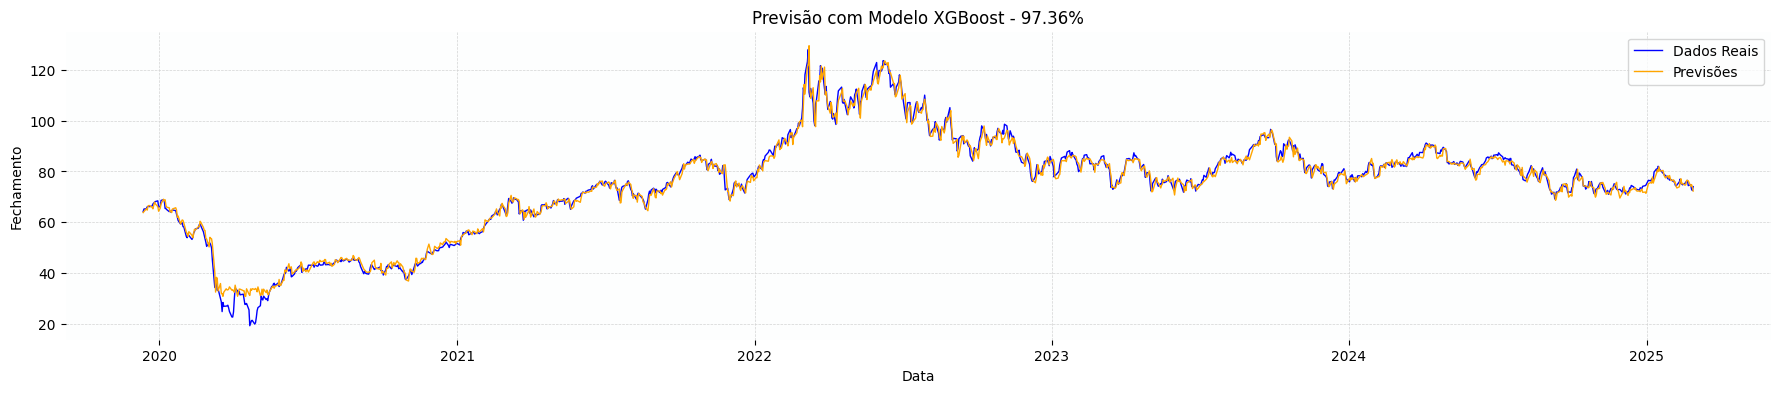

In [85]:
# @title
# Plotar resultados
plt.figure(figsize=(22, 4))
plt.plot(test.index, y_test, label='Dados Reais', color='blue', linewidth=1)  # Linha real
plt.plot(test.index, preds, label='Previsões', color='orange', linewidth=1)  # Previsões
plt.title('Previsão com Modelo XGBoost - 97.36%')
plt.xlabel('Data')
plt.ylabel('Fechamento')
plt.legend()
plt.grid()
plt.show()



**Gráfico 18:** Desempenho do Modelo XGBoost. O gráfico mostra uma comparação entre os dados reais do Brent (em azul) e as previsões geradas por um modelo XGBoost (em laranja) ao longo do tempo.

### 3.2 Modelo Prophet

**O que é:** O Prophet é um modelo de previsão de séries temporais, desenvolvido pelo Facebook, que lida bem com tendências e sazonalidades. Ele utiliza médias móveis e suavização exponencial para ajustar tendências de longo prazo, capturando variações sazonais e eventos externos, sendo eficaz em dados financeiros complexos.


**Resultado:** O Prophet teve um MAPE de 20.35 %.


**Observações:** Este modelo apresenta a menor precisão (79,65%) entre os três. Diferentemente dos outros, o Prophet mostra um intervalo de confiança (área cinza) e cobre um período histórico mais longo (desde 2008). Observa-se que as previsões começam apenas em 2020, e há divergências significativas em alguns períodos, especialmente em 2023-2024, onde o modelo não captura adequadamente algumas oscilações de preço.

In [86]:
# @title
# Ajustando os dados para Prophet
train_prophet = train.rename(columns={"fechamento": "y"}).copy()
train_prophet["ds"] = train_prophet.index

test_prophet = test.rename(columns={"fechamento": "y"}).copy()
test_prophet["ds"] = test_prophet.index

# Criando o modelo Prophet
model = Prophet(daily_seasonality=True)
model.add_regressor("abertura")
model.fit(train_prophet)

# Criando datas futuras para a previsão
future = model.make_future_dataframe(periods=len(test))
future = future.set_index("ds").join(pd.concat([train, test])["abertura"]).reset_index()

# Preenchendo valores ausentes de "abertura"
future["abertura"] = future["abertura"].ffill()

# Fazendo previsão
forecast = model.predict(future)

# Preparando os dados para avaliação
preds = forecast[["ds", "yhat"]].set_index("ds").tail(len(test))
y_test = test_prophet.set_index("ds")["y"]

# Calculando métricas
metrics_pr = calculate_metrics(y_test, preds["yhat"])
print("\nProphet Metrics:")
print_metrics(metrics_pr)



DEBUG:cmdstanpy:input tempfile: /tmp/tmpdel6w_l4/c17tb2iy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdel6w_l4/u4osm2k7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99725', 'data', 'file=/tmp/tmpdel6w_l4/c17tb2iy.json', 'init=/tmp/tmpdel6w_l4/u4osm2k7.json', 'output', 'file=/tmp/tmpdel6w_l4/prophet_model6prtwvzc/prophet_model-20250304020054.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:00:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:00:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Prophet Metrics:
MAE: 14.749836402334529
MSE: 358.9347409005401
MAPE: 20.35 %


In [87]:
print("Acurácia:", f"{100 - 20.35: .2f}%")

Acurácia:  79.65%


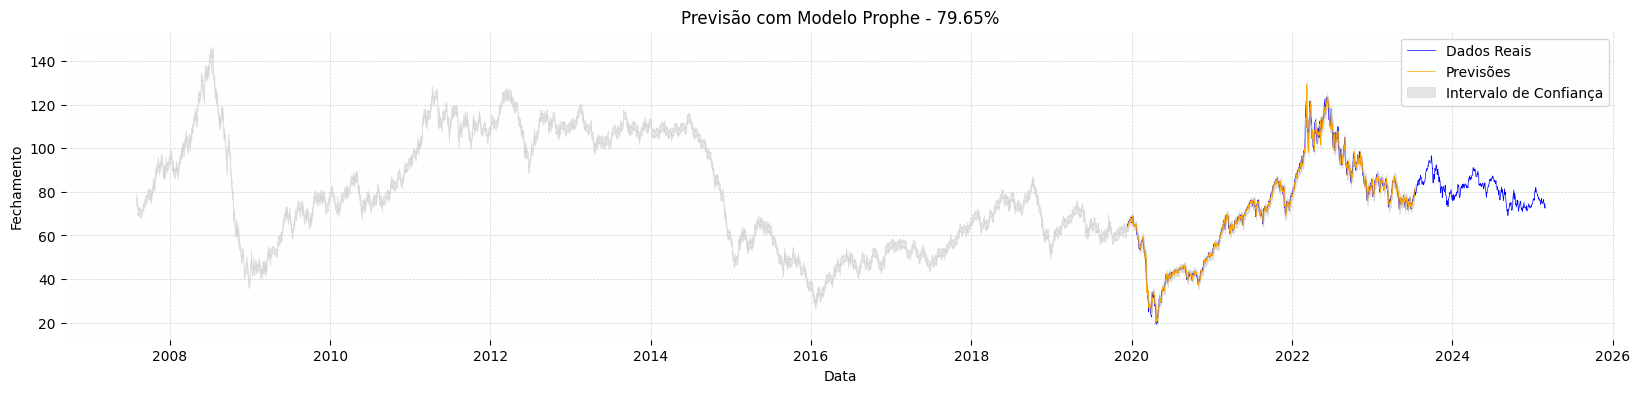

In [88]:
# @title
# Plotar resultados do modelo prophet
plt.figure(figsize=(20, 4))
plt.plot(y_test.index, y_test, label='Dados Reais', color='blue', linewidth=0.5)  # Linha fina
plt.plot(preds.index, preds['yhat'], label='Previsões', color='orange', linewidth=0.5)  # Linha fina
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2, label='Intervalo de Confiança', linewidth=0.5)
plt.title('Previsão com Modelo Prophe - 79.65%')
plt.xlabel('Data')
plt.ylabel('Fechamento')
plt.legend()
plt.grid()
plt.show()

**Gráfico 18:** Desempenho do Modelo Prophet. O gráfico apresenta a previsão do modelo Prophet aplicado à série temporal do Brent, comparando dados reais (linha azul) com as previsões do modelo (linha laranja) e o intervalo de confiança (área cinza).



### 3.3 Modelo SARIMAX

**O que é:** O SARIMAX é um modelo de séries temporais que integra autoregressão, médias móveis, sazonalidade e variáveis exógenas, sendo especialmente útil para dados financeiros com padrões sazonais e influenciados por fatores externos, como taxas de juros e indicadores econômicos.


**Resultado:** O SARIMAX teve um MAPE de 1.73 %.


**Observações:** Este modelo apresenta a maior precisão entre os três (98,27%). As linhas de previsão e valores reais praticamente se sobrepõem, tornando difícil distinguir uma da outra em vários trechos. O SARIMAX captura com excelência os movimentos de alta volatilidade (como o pico de 2022) e também os períodos de tendência. O ajuste é excepcionalmente bom em todo o intervalo temporal analisado.

In [89]:
p, d, q

(2, 1, 227)

In [90]:
# @title
# Modelo SARIMAX
exog_train = train[["abertura"]]
exog_test = test[["abertura"]]

model = sm.tsa.statespace.SARIMAX(
    train["abertura"],
    exog=exog_train,
    order=(
        p,
        d,
        10,
    ),  # q muito grande faz com que o modelo fique muito complexo e lento
    seasonal_order=(1, 0, 0, 12),
)
results = model.fit()

preds = results.get_forecast(steps=len(test), exog=exog_test).predicted_mean

metrics_sarimax = calculate_metrics(test["fechamento"], preds)
print("SARIMAX Metrics:")
print_metrics(metrics_sarimax)

SARIMAX Metrics:
MAE: 1.2281504296386694
MSE: 3.124917408120124
MAPE: 1.73 %


In [91]:
print("Acurácia:", f"{100 - 1.73: .2f}%")

Acurácia:  98.27%


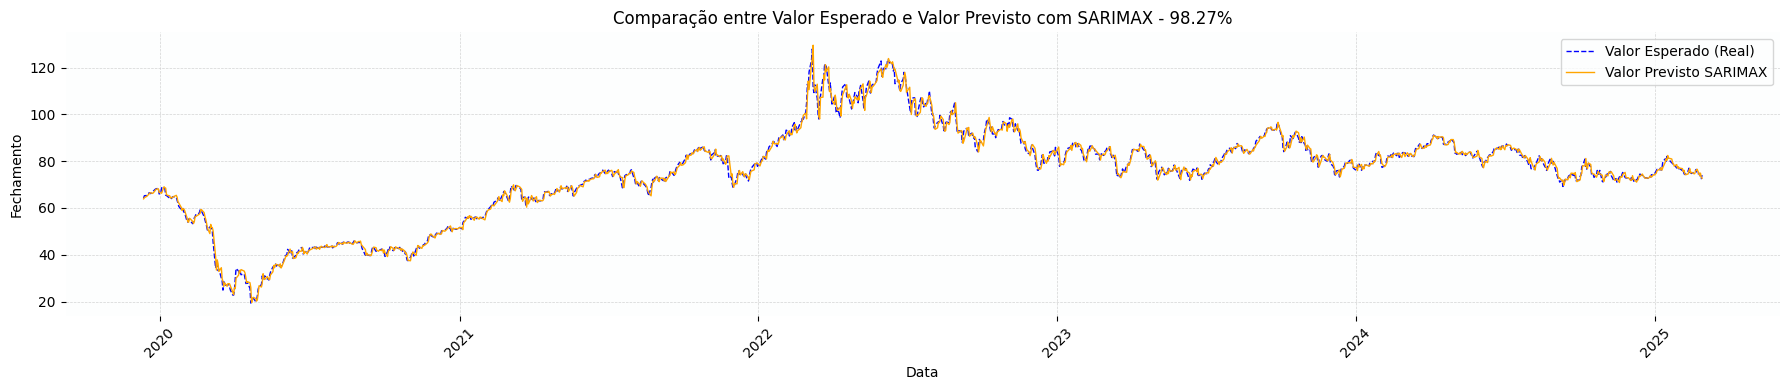

In [92]:
# @title
import pandas as pd
import matplotlib.pyplot as plt

# Plotando os resultados
plt.figure(figsize=(18, 4))
plt.plot(test.index, test["fechamento"], label='Valor Esperado (Real)', color='blue', linestyle='--')
plt.plot(test.index, preds, label='Valor Previsto SARIMAX', color='orange')
plt.title('Comparação entre Valor Esperado e Valor Previsto com SARIMAX - 98.27%')
plt.xlabel('Data')
plt.ylabel('Fechamento')
plt.legend()
plt.xticks(rotation=45)  # Rotaciona as labels do eixo x para melhor legibilidade
plt.grid()
plt.tight_layout()
plt.show()


**Gráfico 19:** Desempenho do Modelo SARIMAX. O gráfico apresenta a previsão do modelo SARIMAX aplicado à série temporal do Brent, comparando dados reais (linha azul) com as previsões do modelo (linha laranja).

## Conclusão

In [93]:
# @title
# Criar DataFrame com as métricas
df = pd.DataFrame(
    [metrics_xgb, metrics_pr, metrics_sarimax],
    columns=["MAE", "MSE", "MAPE"],
    index=["XGBoost", "Prophet", "SARIMAX"],
)

# Calcular a acurácia e adicionar como nova coluna
df["Acurácia (%)"] = 100 - df["MAPE"]

# Ordenar DataFrame pela coluna MAPE
df_sorted = df.sort_values(by="MAPE", ascending=True)

# Estilizar a tabela
styled_df = df_sorted.style.format({
    "MAE": "{:.2f}",
    "MSE": "{:.2e}",
    "MAPE": "{:.6f}",
    "Acurácia (%)": "{:.2f}"
}).set_caption("Comparação de Modelos")

# Exibir a tabela estilizada (no Jupyter Notebook, use styled_df)
styled_df


,MAE,MSE,MAPE,Acurácia (%)
SARIMAX,1.23,3.12e+00,1.732669,98.27
XGBoost,1.58,5.41e+00,2.638373,97.36
Prophet,14.75,3.59e+02,20.349241,79.65


Para avaliar a precisão das previsões, três modelos foram comparados: SARIMAX, Prophet e XGBoost. Utilizando o erro percentual médio absoluto (MAPE) como métrica, o SARIMAX apresentou o melhor desempenho, com um MAPE de 1,74%. O XGBoost, com um MAPE de 2,64%, também demonstrou bons resultados. Já o Prophet, com um MAPE significativamente maior (20,35%), mostrou dificuldades em capturar as nuances dos dados da série do Brent.

Diante dos resultados, o modelo SARIMAX se mostrou o mais adequado para prever o comportamento complexo do Brent pelos seguintes motivos:

1. Apresenta a maior precisão (98,27%) entre os três modelos analisados.
2. Captura com excelência tanto tendências quanto flutuações de curto prazo
3. Seu desempenho é consistente ao longo de todo o período analisado
4. Alinha-se com a característica de autocorrelação do Brent identificada anteriormente, onde os coeficientes PACF indicavam a importância dos lags mais recentes, enquanto o ACF mostrava persistência - características que o SARIMAX é especialmente projetado para modelar através de seus componentes sazonal e autorregressivo
5. É particularmente adequado para séries temporais com potenciais componentes sazonais, como o mercado de petróleo que pode sofrer influências cíclicas de fatores econômicos e geopolíticos.
6. Apesar do XGBoost apresentar resultado muito próximo o SARIMAX demonstra ligeira superioridade na precisão e maior adequação conceitual à estrutura temporal identificada na série do Brent.

## Baixar Modelo SARIMAX

In [94]:
import joblib
from google.colab import files

# Salvar o modelo
joblib.dump(results, 'sarimax_model.pkl')


# Baixar o modelo
files.download('sarimax_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>